# Welcome to Option 1: Point Workflow

Welcome to the Point-Based Workflow. In this notebook, we will demonstrate the use of Earth Observation (EO) for monitoring general crop productivity using time-series Normalized Difference Vegetation Index (NDVI) data, and on exploring the associations between productivity and climate variables. Our analysis will examine productivity and climate relationships within the context of refugee settlements, focussing on a district in northern Uganda called Ajumani.
This notebook will show how to use point-based sampling to assess crop productivity and its relationship to temperature and precipitation. We will compare two locations: one near a refugee settlement and one slightly distant from it, highlighting potential variations in crop productivity measured through NDVI.
In this workflow, we will maximize the use of Python libraries for time-series processing and use Google Earth Engine (GEE) for basic satellite imagery processing and value extraction.

---

## Overview of Point-Based Workflow

Before we get started, let's review the point-based workflow. This approach typically analyzes one or more pixels over time, representing a very specific location on the Earth. This method is particularly useful when we have specific knowledge about a location that is of particular interest, or want to analyze a sample of locations that is representative of a broader region of interest.

### Benefits of Point-Based Workflow

The point-based workflow offers several advantages, particularly for certain applications:
- **Simplified Data Management:** Analyzing one or a relative small number of points over time results in a straightforward data structure, avoiding the complexity of handling large areas with many pixels.
- **Focused Analysis:** Ideal for targeted studies where specific locations are of interest, such as monitoring individual farms or specific environmental conditions.
- **Efficient Processing:** Smaller data size makes it practical to process data offline, reducing computational requirements.
- **Flexibility with Irregular Time Series:** Easier to handle irregular time series data and missing values using Python libraries such as Pandas and Scipy, without the need for image mosaicking or extensive preprocessing.

### Practical Applications

While both point-based and *region-based workflows can be used for various analyses, the point-based approach is particularly beneficial for:
- **Assessing Crop Productivity:** Focusing on NDVI data over time for specific points allows for detailed monitoring and management of individual plots.
- **Studying Environmental Factors:** Examining the relationship between crop productivity and environmental factors like temperature and precipitation at specific locations provides targeted insights.
- **Comparative Analysis:** Comparing crop productivity at specific points near and distant from refugee settlements can highlight localized impacts and variations.

In this notebook, you will learn how to effectively implement the point-based workflow using Python and GEE for data processing and manipulation tasks related to environmental and agricultural analysis.

*A region-based workflow refers to the process of performing data manipulation and analysis at the image level, involving more complex array operations. The result is often displayed as an image. As mentioned in the presentation, the GEE method supports cloud computing with image-level data operations, but requires more programming expertise in GEE methods.

---

## Notebook Summary

We summarize this notebook into four parts:

### Part 1: Setup and Preparation
- **Library Import:** Import necessary Python libraries.
- **GEE Authentication:** Authenticate with Google Earth Engine.
- **File Upload:** Upload relevant files, from Google Drive or directly to this Colab working folder (side bar on the left).
- **Function Definitions:** Define the functions mostly for Part 2 but may be used throughout the notebook.

### Part 2: Data Extraction
- **NDVI Data Extraction:** Extract NDVI data for a single point from both Sentinel-2 and MODIS using GEE Python API.
- **Precipitation and Temperature Extraction:** Extract and process precipitation and temperature data using GEE.
- **Data Management:** Handle missing and noisy data through gap-filling and curve smoothing with Pandas and Scipy.

### Part 3: Productivity Calculation and Environmental Analysis
- **Calculate Productivity Metrics:** Calculate crop productivity metrics using a method similar to [TIMESAT](https://web.nateko.lu.se/timesat/timesat.asp).
- **Productivity Analysis:** Analyze the relationship between productivity, precipitation, and temperature.

### Part 4: Contextual Analysis
- **Comparative Analysis:** Compare NDVI values for two locations, each with a pair of points: one point within a refugee settlement and one point slightly distant from it. This comparison aims to understand the impact of proximity to refugee settlements on crop productivity.

By the end of this notebook, you will have hands-on experience with data processing and manipulation techniques using Python and GEE for specific environmental and agricultural tasks.

---

### Part 1: Setup and Preparation

In this section, we will import the required libraries, authenticate with Google Earth Engine, upload relevant files, and define the functions used throughout the notebook.

Colab comes with all the necessary packages pre-installed, so you should be able to run the code without any additional installations. You have two options for managing your files:

1. **Mount Google Drive:** You can mount your Google Drive and access all the necessary files stored there.
2. **Upload Files Directly:** Alternatively, you can upload the files directly to the panel on the left. However, please note that these files will be erased after the Colab session is disconnected.




In [1]:
import ee
import geemap
from ipywidgets import HBox
import json
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
from scipy.integrate import trapz
from sklearn.metrics import r2_score

import warnings

#### Configure GEE Authentication and Google Drive Access

#### Using a Private Key File for Authentication

You can use a private key file for authentication. Follow this [guide](https://developers.google.com/earth-engine/guides/service_account#create-a-private-key-for-the-service-account) to create a private key for your service account. Alternatively, you can search, for example, in ChatGPT for "How can I authenticate a Google Earth Engine (GEE) account using a private key?"

#### Mounting Google Drive to Make it Accessible to Colab

This allows Colab to read your private key and access your study area polygon.

#### Granting Google Drive Access

When exporting tasks write files to Google Drive, they need appropriate access; otherwise, you won't be able to find your results in Google Drive. This is a different process from mounting Google Drive to Colab.

In some cases, you may need to share your Google Drive folder with your service account email (generated upon creation of the service account). This ensures that any exported tables (or image) can be written to the shared folder. To share a folder with your service account:

1. Go to Google Drive.
2. Right-click on the folder you want to share.
3. Select "Share."
4. Enter the service account email address and set the appropriate permissions.
5. Click "Send."

By completing these steps, you ensure that your service account can access and write to your Google Drive folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# replace the path and key name below with your own
key_file = "/content/drive/MyDrive/NASA_ARSET2024/nasa-arset2024-94c746911292.json"
credentials = ee.ServiceAccountCredentials('', key_file=key_file)
ee.Initialize(credentials)

If you have trouble authenticating with a key, uncomment the two lines below and run these instead

In [ ]:
# ee.Authenticate()
# ee.Initialize()

#### Helper functions

Now we define some helper functions:

1. `load_geojson()`: Loads a GeoJSON file, which we will use to display our study area polygons: Adjumani and a smaller area of interest called AOI.
2. `s2_mask_clouds()`: A cloud mask function for Sentinel-2.
3. `modis_mask_qa()`: Retrieves MODIS NDVI with good and usable quality.
4. `modis_scale_ndvi()`: Scales MODIS NDVI by multiplying by a scaling factor of 0.0001.
5. `s2_calc_ndvi()`: Calculates NDVI for Sentinel-2 based on its red and near-infrared (NIR) bands.
6. `clip_aoi()`: Clips the image to a polygon.
7. `date_range()`: Generates a list of dates, used for calculating annual precipitation.
8. `export_image_asset()`: Exports the image to Google Earth Engine asset.
9. `export_image_drive()`: Exports the image to Google Drive.
10. `export_featurecollection_drive()`: Exports a FeatureCollection to Google Drive in CSV format.
11. `mask_cropland()`: Applies a cropland mask to the image.
12. `calculate_annual_precipitation()`: Calculates precipitation by summing daily precipitation images in CHIRPS data to a sum image.
13. `scale_temp()`: Scales temperature values.



In [6]:
def load_geojson(fn):
    with open(fn) as f:
        geojson_f = json.load(f)
    return geojson_f

def s2_mask_clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0)\
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    masked_image = image.updateMask(mask)
    masked_image = masked_image.set('system:time_start',
                                    image.get('system:time_start'))
    return masked_image

def mask_modis_qa(band_name):
    def apply_mask(img):
        # Keep the good quality image. In this quality band, 0 means "good"
        # observation, 1 means "not good but also works" data.
        ndvi = img.select([band_name])
        mask = img.select('SummaryQA').eq(0).Or(img.select('SummaryQA').eq(1))
        masked = ndvi.updateMask(mask)
        return masked.rename(band_name).set('system:time_start',
                                            img.get('system:time_start'))
    return apply_mask

def modis_scale_ndvi(image):
    return image.multiply(0.0001).set('system:time_start',
                                      image.get('system:time_start'))

def s2_calc_ndvi(image):
    scale_factor = 0.0001
    scaled_image = image.select(['B4', 'B8']).multiply(scale_factor)

    ndvi = scaled_image.expression(
        '((NIR - RED) / (NIR + RED))', {
            'NIR': scaled_image.select('B8'),
            'RED': scaled_image.select('B4')
        }).rename('NDVI')

    ndvi = ndvi.set('system:time_start', image.get('system:time_start'))
    return ndvi

def clip_aoi(image, aoi):
    return image.clip(aoi).set('system:time_start',
                               image.get('system:time_start'))


# Define the date range
def date_range(start_date = '2019-02-10', end_date = '2020-02-10',
               interval = 16):
    start_date_obj = ee.Date(start_date)
    end_date_obj = ee.Date(end_date)
    diff_days = (end_date_obj.difference(start_date_obj, 'day') \
                 .divide(interval).int()
    )
    date_range = (ee.List.sequence(0, diff_days.subtract(1)) \
                  .map(lambda day: start_date_obj.advance(day, 'day'))
    )

    return date_range

def export_image_asset(image, description, assetId, crs, scale, region):
    export_task = ee.batch.Export.image.toAsset(
        image= image,
        description= description,
        assetId= assetId,
        crs= crs,
        scale= scale,
        region= region);

    export_task.start()

def export_featurecollection_drive(collection, description, folder,selectors):

    task = ee.batch.Export.table.toDrive(
        collection=collection,
        description=description,
        folder=folder,  # Optional: specify the folder in Google Drive
        selectors=selectors,
        fileFormat='CSV')

    # Start the export task
    task.start()

def calculate_annual_precipitation(year, start_month, start_day):
    start_date = ee.Date.fromYMD(year, start_month, start_day)
    end_date = start_date.advance(1, 'year')
    annual_precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterDate(start_date, end_date) \
        .sum() \
        .set('year', year) \
        .set('system:time_start', start_date.millis()) \
        .rename('annual_precipitation')
    return annual_precip

# Function to scale and convert temperature
def scale_temp(image):
    return (image.multiply(0.02).subtract(273.15). \
            set('system:time_start', image.get('system:time_start'))
    )

#### Load and Visualize Study Area

We use this `adjumani` file primarily to filter imagery to this region. But it's also useful to show a map highlighting where Adjumani and the UNHCR-identified refugee settlements are located.

First, we load the Adjumani and refugee settlement data as Python JSON files. Then, we convert them to Google Earth Engine (GEE) objects called `ee.FeatureCollection`. We create two maps side by side: the left one shows Adjumani in black, the refugee settlements in red, and a blue point, an `ee.FeatureCollection` from an `ee.Geometry.Point` that we defined as our first point of investigation. The right map is a zoomed-in version of the left map centered on the point, using the ESRI World Imagery as the basemap. As you can see, the point is placed on a fairly large commercial-like field.

**Note**: To access these geojson files, please create a shortcut to the `NASA_ARSET2024` data folder shared with you, and add the shortcut directly under your `MyDrive` folder.  You can add to a different location on your Drive also, but will have to adjust the paths below to match.


In [7]:
adjumani = '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/Adjumani.geojson'
adjumani_geojson = load_geojson(adjumani)
# # Convert GeoJSON to ee.FeatureCollection
adjumani = ee.FeatureCollection(adjumani_geojson)

settlements = '/content/drive/MyDrive/NASA_ARSET2024/Study_Area/' +\
  'UNHCR_poc_boundaries-Uganda.geojson'
refugee_settlements = load_geojson(settlements)
refugee_settlements = ee.FeatureCollection(refugee_settlements)



In [8]:
# Define the point location.
#point = ee.Geometry.Point([31.733691, 3.327846])
point = ee.Feature(ee.Geometry.Point([31.733691, 3.327846]), {'id': 'point1'})

# Define map objects centered on the point.
map_adjumani = (geemap.Map(center=[3.327846, 31.733691], \
                           zoom=10, layout={'height': '400px'})
)
map_point_esri = (geemap.Map(center=[3.327846, 31.733691], \
                            zoom=16, layout={'height': '400px'})
)

# Define styles for the Adjumani polygon and refugee settlements.
adjumani_style = {
    'color': 'black',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
settlements_style = {
    'color': 'red',
    'fillColor': '00000000',  # transparent fill
    'width': 2
}
point_style = {'color': 'blue', 'radius': 5, 'fillColor': 'blue'}

# Add the Adjumani polygon, refugee settlements, and point to the first map.
map_adjumani.addLayer(adjumani.style(**adjumani_style), {}, 'Adjumani')
(map_adjumani.addLayer(refugee_settlements.style(**settlements_style), \
 {}, 'Refugee Settlements')
)
map_adjumani.addLayer(point, {'color': 'blue'}, 'Point')

# Add the ESRI World Imagery basemap, Adjumani polygon, refugee settlements, and
# point to the second map.
map_point_esri.add_basemap('Esri.WorldImagery')
map_point_esri.addLayer(adjumani.style(**adjumani_style), {}, 'Adjumani')
(map_point_esri.addLayer(refugee_settlements.style(**settlements_style), {}, \
                        'Refugee Settlements'))
map_point_esri.addLayer(point, {'color': 'blue'}, 'Point')

# Display the maps side by side.
display(HBox([map_adjumani, map_point_esri]))

### Part 2: Data Extraction and Processing

In this section, we will import and process satellite data. We use the `ee` method to request data and perform processing on the Google Earth Engine (GEE) platform. This includes selecting the data by providing the name in `ee.ImageCollection`, applying the necessary date filters and data quality screening processes, and clipping to our study area.

To find data details, you can use the search bar in the [GEE Code Editor](https://code.earthengine.google.com/) and refer to its [help page](https://developers.google.com/earth-engine/guides/playground). Additionally, the GEE Code Editor uses JavaScript but works almost identically in the Python API. Note that these datasets may not have the same starting date; for simplicity, we specify a similar date range. For example, Sentinel-2 is not available exactly from 2015-02-10, but the `filterDate()` function will search for dates from this day inclusively until 2024-04-30 exclusively.

The satellite processing workflow follows a pipeline manner where the output of an earlier function serves as the input for the next function. Here is a detailed breakdown:

1. **Sentinel-2 Processing:**
   - We use the [`Harmonized Sentinel-2 dataset`](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) `ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')`.
   - Apply the `filterBounds()` function to keep only scenes that intersect our study area, Adjumani, Uganda.
   - Apply the `filterDate()` function to filter scenes within the specified date range.
   - Use the attribute `CLOUDY_PIXEL_PERCENTAGE` to filter scenes based on cloud cover.
   - Process the filtered scenes using three customized functions: `s2_mask_clouds()`, `s2_calc_ndvi()`, and `clip_aoi()`. These function names are self-explanatory, and you can review their definitions to understand the processing and enhance your coding skills with the GEE Python API.

2. **MODIS Processing:**
   - Acquire NDVI from the MODIS Terra satellite, using the 250m 16-day data product: [`MOD13Q1`](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1) for NDVI (which also includes the Enhanced Vegetation Index (EVI)), so there is no need to calculate NDVI. We apply the date filter and clip function similar to the Sentinel-2 data, using its internal quality assurance band to keep the "good" and "useful" observations.
   - Pay attention to the scaling factors and unit conversions from the raw values, such as converting from Kelvin to Celsius.

3. **CHIRPS Precipitation Data:**
   - Extract precipitation data from [CHIRPS](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY), a global daily precipitation product.
   - Aggregate to the annual sum of precipitation, defined from February 10 of one year to February 9 of the next year, aligning with the unimodal growing seasons.

4. **MODIS Land Surface Temperature Processing:**
   - Notice that we used a MODIS product`MOD13Q1` to acquire NDVI. This time we use another proudct, called [`MOD11A2`](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2) for [Land Surface Temperature](https://earthobservatory.nasa.gov/global-maps/MOD_LSTD_M).
   - Pay attention to the scaling factors and unit conversions from the raw values, such as converting from Kelvin to Celsius.


**Note:** Ensure there is no accidental space after the line-continuation symbol "`\`" as it will cause a syntax error.

*This section should run through instantly as it does not invoke real data computation or downloading processes. It should be understood as a plan that has been made, with the actual data processing to be done in a later section.


In [9]:
# Before gap-filling curve-fitting
s2_raw = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                 .filterBounds(adjumani) \
                 .filterDate('2015-2-10', '2024-04-30') \
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                 .map(s2_mask_clouds) \
                 .map(s2_calc_ndvi) \
                 .map(lambda image: clip_aoi(image, adjumani))

modis_raw = ee.ImageCollection('MODIS/061/MOD13Q1') \
                .filterDate('2000-2-10', '2024-04-30') \
                .map(mask_modis_qa('NDVI')) \
                .map(modis_scale_ndvi) \
                .map(lambda image: clip_aoi(image, adjumani))


# Define the time range and start date for annual precipitation calculation
start_year, start_month, start_day = 2000, 2, 10
end_year = 2024
years = ee.List.sequence(start_year, end_year)
annual_precipitation = (ee.ImageCollection(years.map(lambda year: \
              calculate_annual_precipitation(year, start_month, start_day)))
)


# Get the MODIS Land Surface Temperature (LST) image collection
modis_lst = (ee.ImageCollection('MODIS/061/MOD11A2') \
    .filter(ee.Filter.date('2000-2-10', '2024-4-30')))

# Apply the scaling function to the image collection
lst_daytime = modis_lst.select('LST_Day_1km').map(scale_temp)

#### Data Extraction

Here we use the point that we defined in our study area map. Feel free to change the point by modifying the latitude and longitude.

We defined a function called `reduce_region`, which works on each image of an image collection using `imagecollection.map(reduce_region)`. Each time, it takes an image and extracts the value at a specified scale, which is 250m for MODIS and 10m for Sentinel-2 at their native spatial resolutions. We also rename the NDVI from Sentinel-2 as `NDVI_s2` and from MODIS as `NDVI_mod` for easy distinction.

Again, this step does not invoke real computation.


In [10]:
#point = ee.Geometry.Point([31.733691, 3.328146])  #31.7328667, 3.328829 near
# 4 pixel's joint, shows a polynomial relationship between ndvi_seasonal
# integral with precip only at 10m for MODIS)
#point = ee.Feature(ee.Geometry.Point([31.733691, 3.327846]), {'id': 'point1'})
# Function to extract NDVI values at the point
def reduce_region(image, collection, bname, new_bname, scale):
    reduced = image.select(bname).reduceRegions(
        collection=collection,
        reducer=ee.Reducer.mean(),
        scale=scale
    )

    def rename_and_set_date(feature):
        mean_value = feature.get('mean')
        date_value = ee.Date(image.get('system:time_start'))\
            .format('YYYY-MM-dd')

        return (feature.set(new_bname, mean_value) \
            .set('date', date_value).select([new_bname, 'date','id']))


    return reduced.map(rename_and_set_date)

# Apply the reduceRegion function to each image
ndvi_ts_s2 = (s2_raw.map(lambda image: \
                         reduce_region(image, point,'NDVI','NDVI_s2',10)) \
                         .flatten())
ndvi_ts_mod = (modis_raw.map(lambda image: \
                            reduce_region(image, point,'NDVI','NDVI_mod',250)) \
                            .flatten())

precip_ts = (annual_precipitation.map(lambda image: \
        reduce_region(image, point,
                      'annual_precipitation','annual_precipitation',10)) \
                      .flatten()
                      )
lst_daytime_ts = (lst_daytime.map(lambda image: \
                                 reduce_region(image, point, \
                                               'LST_Day_1km', \
                                               'temperature',1000)).flatten())


#### Check-Point 1: Data Export

You can export the time series to Google Drive using the `export_featurecollection_drive()` function. Here we export the Sentinel-2 and MODIS data separately. We will also use `getInfo()` in the next section to read the time series from the Earth Engine server and make it available offline. After this step, all the analysis will be conducted offline.

We keep the Sentinel-2 and MODIS data in two separate pandas DataFrames for easier data handling, considering their observation frequencies. The MODIS product is nearly daily but is provided as a 16-day composite, while Sentinel-2 has an observation frequency of about 5 days.


In [11]:
export_featurecollection_drive(ndvi_ts_s2,
                               description = 'point_NDVI-timeseries_s2',
                               folder = 'NASA_ARSET2024',
                               selectors=['date','NDVI_s2'])
export_featurecollection_drive(ndvi_ts_mod,
                               description = 'point_NDVI-timeseries_modis',
                               folder = 'NASA_ARSET2024',
                               selectors=['date','NDVI_mod'])


In [12]:
ndvi_ts_s2 = ndvi_ts_s2.getInfo()['features']
ndvi_ts_mod = ndvi_ts_mod.getInfo()['features']
precip_ts = precip_ts.getInfo()['features']
lst_daytime_ts = lst_daytime_ts.getInfo()['features']

ndvi_data_s2 = [feature['properties'] for feature in ndvi_ts_s2]
ndvi_data_mod = [feature['properties'] for feature in ndvi_ts_mod]

precip_data = [feature['properties'] for feature in precip_ts]
lst_data = [feature['properties'] for feature in lst_daytime_ts]

# Create DataFrames from the data
ndvi_s2_df = pd.DataFrame(ndvi_data_s2)
ndvi_mod_df = pd.DataFrame(ndvi_data_mod)
ndvi_s2_df['date'] = pd.to_datetime(ndvi_s2_df['date'])
ndvi_mod_df['date'] = pd.to_datetime(ndvi_mod_df['date'])

precip_df = pd.DataFrame(precip_data)
precip_df['date'] = pd.to_datetime(precip_df['date'])

lst_df = pd.DataFrame(lst_data)
lst_df['date'] = pd.to_datetime(lst_df['date'])

# average the value for s2 if have two ndvi in a date (due to overlap scene)
ndvi_s2_df = ndvi_s2_df.groupby(['date','id']).mean()
ndvi_s2_df.reset_index(inplace=True)


#### A Glance at NDVI Time Series from Sentinel-2 and MODIS




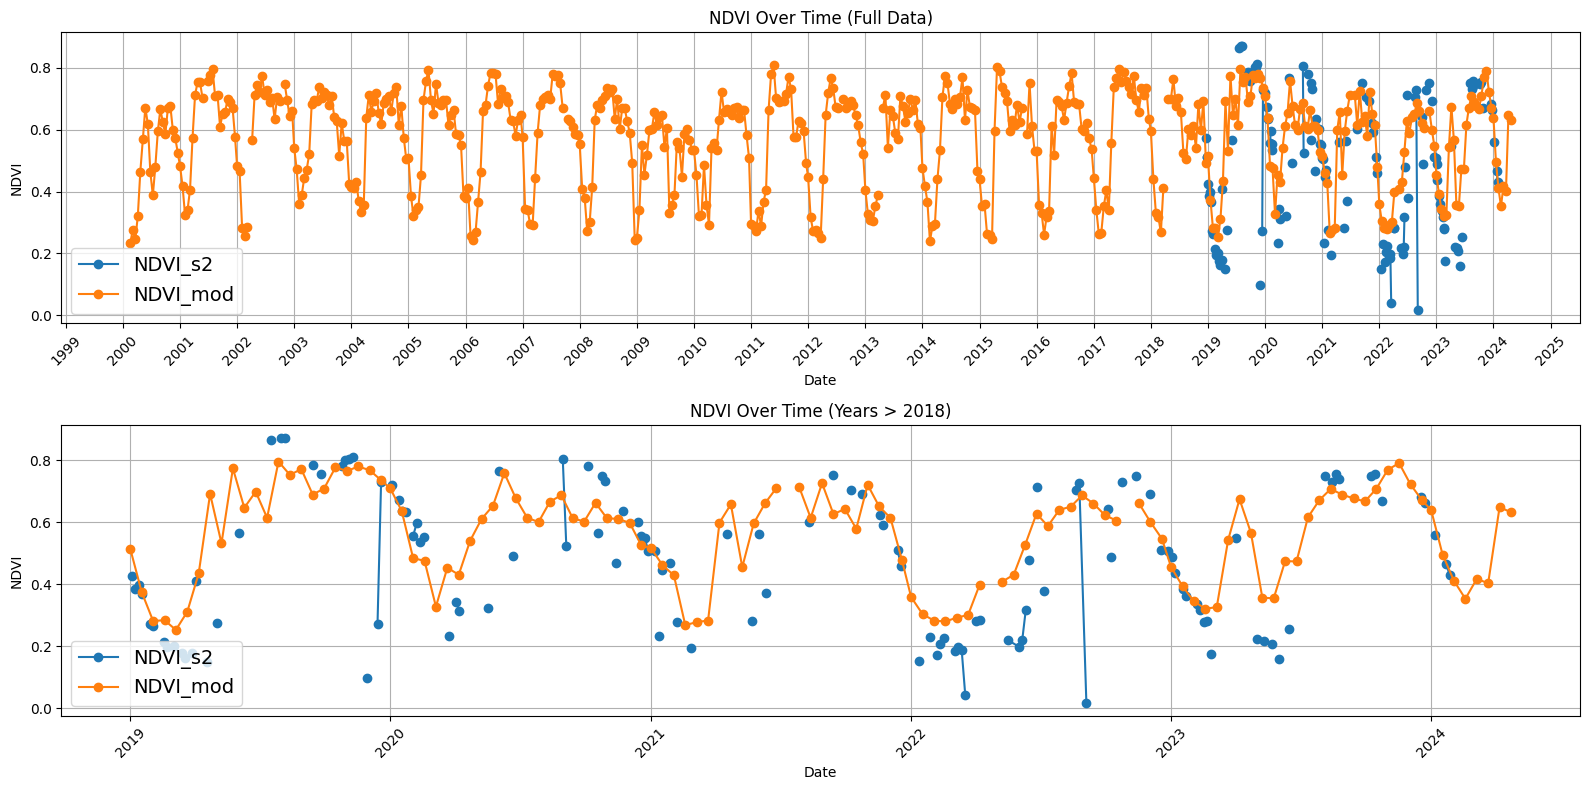

In [13]:
# Filter data for years > 2019
ndvi_s2_df_recent = ndvi_s2_df[ndvi_s2_df['date'] > '2018-12-31']
ndvi_mod_df_recent = ndvi_mod_df[ndvi_mod_df['date'] > '2018-12-31']

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Top plot: Full data
ax1.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2'], marker='o', \
         linestyle='-', label='NDVI_s2')
ax1.plot(ndvi_mod_df['date'], ndvi_mod_df['NDVI_mod'], marker='o', \
         linestyle='-', label='NDVI_mod')
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI')
ax1.set_title('NDVI Over Time (Full Data)')
ax1.legend(fontsize=14, loc='lower left')
ax1.grid(True)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=45)  # Rotate date labels for readability

# Bottom plot: Data for years > 2018
ax2.plot(ndvi_s2_df_recent['date'], ndvi_s2_df_recent['NDVI_s2'], \
         marker='o', linestyle='-', label='NDVI_s2')
ax2.plot(ndvi_mod_df_recent['date'], ndvi_mod_df_recent['NDVI_mod'], \
         marker='o', linestyle='-', label='NDVI_mod')
ax2.set_xlabel('Date')
ax2.set_ylabel('NDVI')
ax2.set_title('NDVI Over Time (Years > 2018)')
ax2.legend(fontsize=14, loc='lower left')
ax2.grid(True)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='x', rotation=45)  # Rotate date labels for readability

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()

The blue points (Sentinel-2) are rarely connected by lines, indicating a high rate of NaN values (missing values) in the sampled dates between two valid observations. If a missing date exists, it breaks the lines, which is especially noticeable for Sentinel-2 (blue).


We can also add the temperature and precipitation data for viewing.


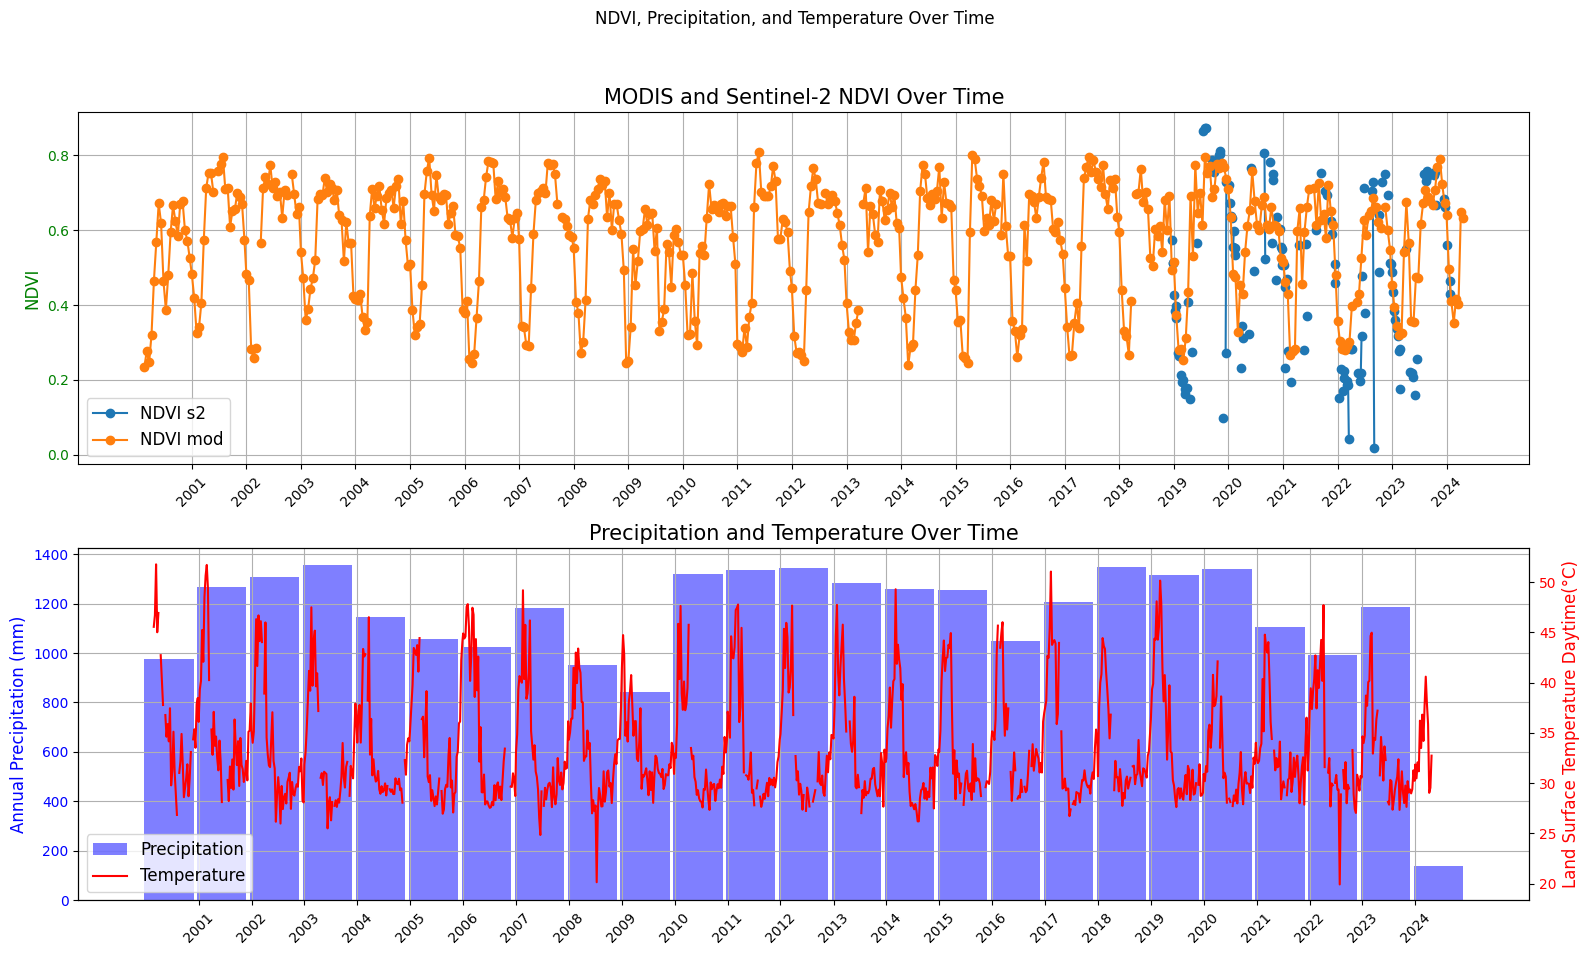

In [14]:
# Plotting
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 10),constrained_layout=True)

# First subplot: MODIS and Sentinel-2 NDVI
# Plot NDVI as dots for ndvi_s2 and ndvi_mod
ax1.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2'], marker='o', linestyle='-',
         label='NDVI s2')

ax1.plot(ndvi_mod_df['date'], ndvi_mod_df['NDVI_mod'], marker='o',
         linestyle='-', label='NDVI mod')

ax1.set_ylabel('NDVI', color='green', fontsize=12)

ax1.tick_params(axis='y', labelcolor='green')

# Set x-ticks to show every year
years = pd.date_range(start=ndvi_mod_df['date'].min(),
                      end=ndvi_s2_df['date'].max(), freq='YS').year
ax1.set_xticks(pd.date_range(start=ndvi_mod_df['date'].min(),
                             end=ndvi_mod_df['date'].max(), freq='YS'))
ax1.set_xticklabels(years, rotation=45)

# Title and legends for the first subplot
ax1.set_title('MODIS and Sentinel-2 NDVI Over Time', fontsize=15)
ax1.legend(loc='lower left', fontsize=12)

# Add grid
ax1.grid(True)

# Second subplot: Precipitation and Temperature
# Plot precipitation as bars
ax3.bar(precip_df['date']+ pd.DateOffset(months=4),
        precip_df['annual_precipitation'],
        width=340, alpha=0.5, color='blue', label='Precipitation')

ax3.set_ylabel('Annual Precipitation (mm)', color='blue', fontsize=12)
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for temperature
ax4 = ax3.twinx()
ax4.plot(lst_df['date'], lst_df['temperature'], color='red', linestyle='-',
         label='Temperature')
ax4.set_ylabel('Land Surface Temperature Daytime(°C)', color='red', fontsize=12)
ax4.tick_params(axis='y', labelcolor='red')

# Set x-ticks to show every year
years = pd.date_range(start=precip_df['date'].min(),
                      end=precip_df['date'].max(), freq='YS').year
ax3.set_xticks(pd.date_range(start=precip_df['date'].min(),
                             end=precip_df['date'].max(), freq='YS'))
ax3.set_xticklabels(years, rotation=45)

# Title and legends for the second subplot
ax3.set_title('Precipitation and Temperature Over Time', fontsize=15)

# Combine legends
lines_labels = [ax3.get_legend_handles_labels(),
                ax4.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax3.legend(lines, labels, loc='lower left', fontsize=12)

# Add grid
ax3.grid(True)

# Title for the whole figure
fig.suptitle('NDVI, Precipitation, and Temperature Over Time')

# Adjust layout to prevent clipping of labels and ensure readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to make space for title
plt.show()


#### Fill Missing Values



Now we know there are plenty of missing values in Sentinel-2 (s2). To fill the missing dates, we can use the nearest available value (blue) to fill the missing points, or a linear interpolation method (orange). Which one do you think makes more sense? Consider the crop growth process over time and the impact of interpolation on extracting crop productivity metrics, such as the seasonal maximum NDVI and the NDVI seasonal integral.

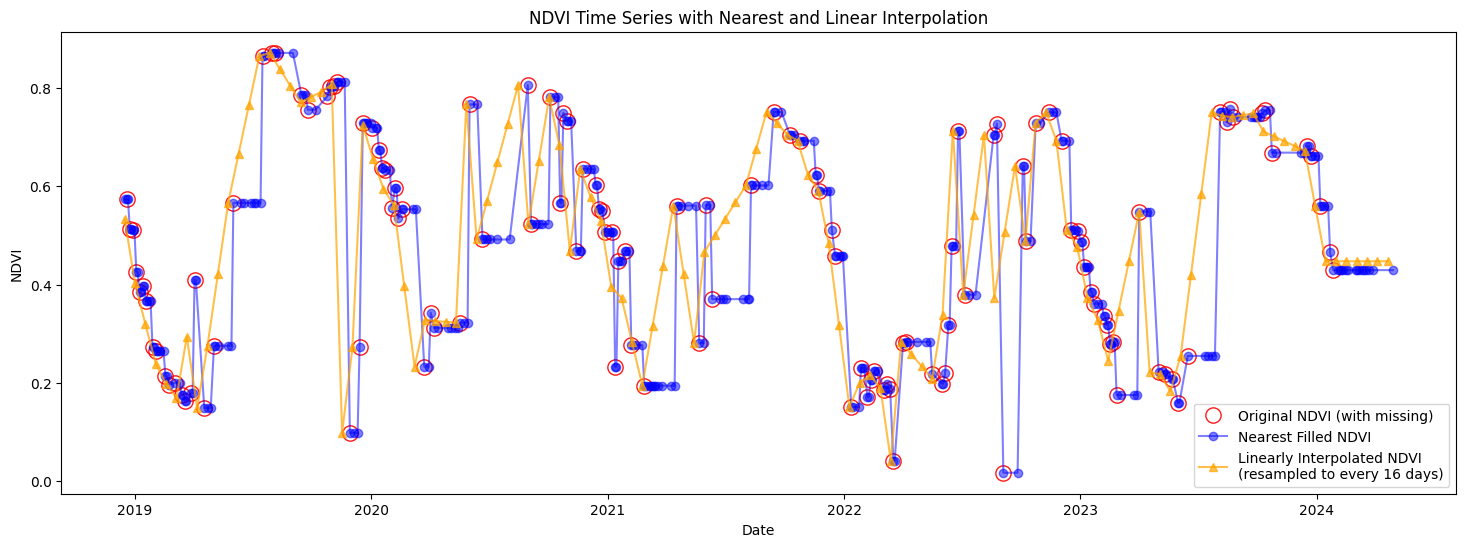

In [15]:
ndvi_s2_df['NDVI_s2_nearest'] = ndvi_s2_df['NDVI_s2'].ffill().bfill() \
        .interpolate(method='nearest')
ndvi_s2_df_linear = ndvi_s2_df.copy()
ndvi_s2_df_linear.set_index('date', inplace=True)
ndvi_s2_df_linear = ndvi_s2_df_linear[['NDVI_s2']] \
        .resample('16D').mean()
ndvi_s2_df_linear['NDVI_s2_linear'] = ndvi_s2_df_linear['NDVI_s2'] \
        .interpolate(method='linear')

# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2'], 'o', \
         label='Original NDVI (with missing)', color='red', alpha=0.9, \
         markersize=11, markerfacecolor='none')  # Modified line
plt.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2_nearest'], 'o-', \
         label='Nearest Filled NDVI', color='blue', alpha=0.5)
plt.plot(ndvi_s2_df_linear.index, ndvi_s2_df_linear['NDVI_s2_linear'], '^-', \
         label='Linearly Interpolated NDVI \n(resampled to every 16 days)', \
         color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series with Nearest and Linear Interpolation')
plt.legend()
plt.show()


#### Curve Smoothing
We will use the nearest fill method for now. To further reduce noise (sharp spikes and dents) in the data, we apply a Savitzky-Golay (S-G) filter. This helps to mitigate the impact of noise on our estimation of the NDVI trend. The S-G filter works by fitting a polynomial to the data points within a moving window. Unlike some other smoothing techniques, the S-G filter does not assume that the NDVI curve should follow a specific shape, such as a bell curve indicating green-up and green-down processes. Instead, it fits a polynomial line to the points within each window independently.

This means that the smoothed data may not perfectly resemble the natural seasonal trajectory of vegetation. Additionally, the smoothed curve may have values between the high and low NDVI points. In reality, sharp dips in NDVI during peak growing times are more likely to be noise. Therefore, it is important to balance the influence these dips have on pulling down the overall curve. We can achieve this by giving higher values more weight.

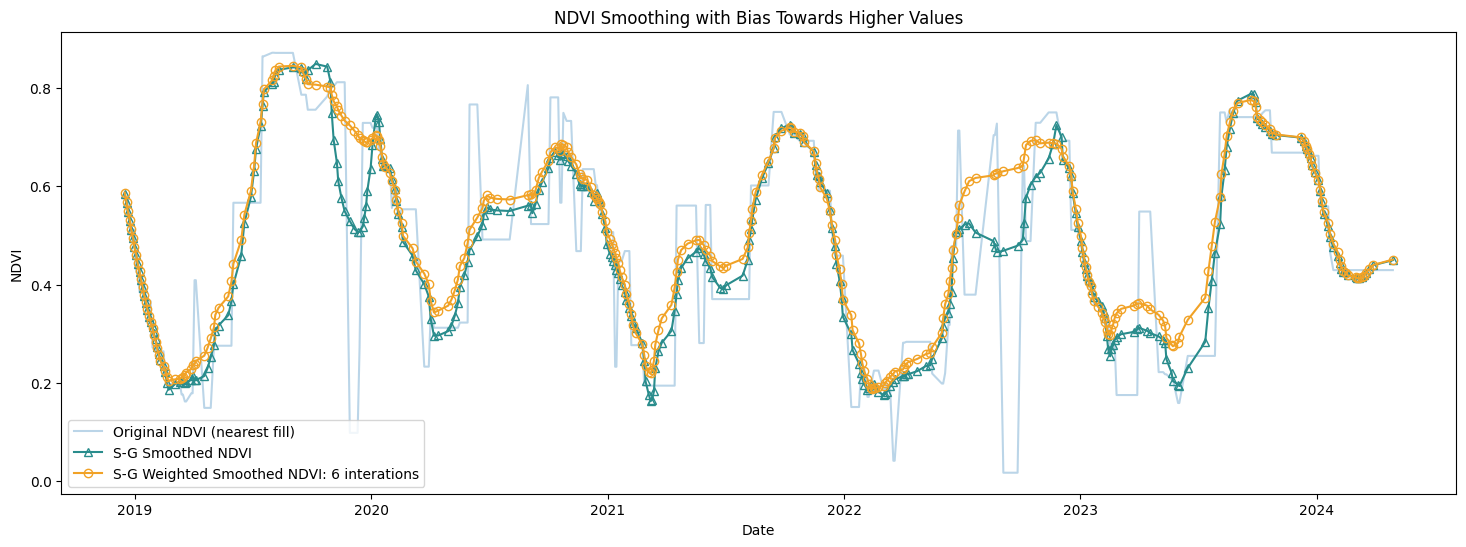

In [16]:
# Apply Savitzky-Golay filter
window_length = 21  # Window length must be odd
polyorder = 2       # Polynomial order
iter_windowlength = 21
up_iter = 6

# Ensure the window length is smaller than the series length
if len(ndvi_s2_df) > window_length:
    # Apply Savitzky-Golay filter to the original data
    ndvi_s2_df['NDVI_s2_smooth'] = savgol_filter(ndvi_s2_df['NDVI_s2_nearest'],
                                                 window_length, polyorder)

    ndvi_s2_df['NDVI_s2_smooth'] = np.where(
        np.isnan(ndvi_s2_df['NDVI_s2_smooth']), ndvi_s2_df['NDVI_s2_nearest'],
        ndvi_s2_df['NDVI_s2_smooth']
    )

    # Apply a bias towards higher values
    # Define a weight function that gives higher weights to higher values
    weights = ndvi_s2_df['NDVI_s2_nearest'] / \
        ndvi_s2_df['NDVI_s2_nearest'].max()

    # Calculate the weighted average of the original and smoothed data
    ndvi_s2_df['NDVI_s2_weighted_smooth'] = ndvi_s2_df['NDVI_s2_smooth']
    for i in range(up_iter):

      ndvi_s2_df['NDVI_s2_weighted_smooth'] = (
          ndvi_s2_df['NDVI_s2_nearest'] * weights + \
          ndvi_s2_df['NDVI_s2_weighted_smooth']  * (1 - weights)
      )
      ndvi_s2_df['NDVI_s2_weighted_smooth'] = savgol_filter(
          ndvi_s2_df['NDVI_s2_weighted_smooth'], iter_windowlength, polyorder
      )
      ndvi_s2_df['NDVI_s2_weighted_smooth'] = np.where(
          np.isnan(ndvi_s2_df['NDVI_s2_weighted_smooth']),
          ndvi_s2_df['NDVI_s2_nearest'],
          ndvi_s2_df['NDVI_s2_weighted_smooth']
      )


plt.figure(figsize=(18, 6))
plt.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2_nearest'],
         label='Original NDVI (nearest fill)', alpha=0.3)
plt.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2_smooth'],
         label='S-G Smoothed NDVI',  marker='^', color='#298c8c',
         markerfacecolor='none')
plt.plot(ndvi_s2_df['date'], ndvi_s2_df['NDVI_s2_weighted_smooth'],
         label='S-G Weighted Smoothed NDVI: {} interations'.format(up_iter), marker='o', color='#f1a226',
         alpha=1, markerfacecolor='none')


plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Smoothing with Bias Towards Higher Values')
plt.legend(loc='lower left')
plt.show()

#### Repeat the process for MODIS

The MODIS 16-day composite is not very noisy, so one application of the Savitzky-Golay (S-G) filter might be sufficient. Since each observation is taken every 16 days, it is important to choose an appropriate window size for the S-G filter. A suitable window size should balance smoothing the data while preserving important trends. For MODIS data, you might consider a window size that covers several observations, such as 5 to 7 observations (approximately 80 to 112 days), to effectively smooth short-term noise while capturing seasonal variations in vegetation.

MODIS has over 20 years of observations, providing a rich dataset for analysis. We will use MODIS data for the subsequent crop productivity metrics calculation and analysis, leveraging its extensive temporal coverage to understand long-term trends in vegetation health.



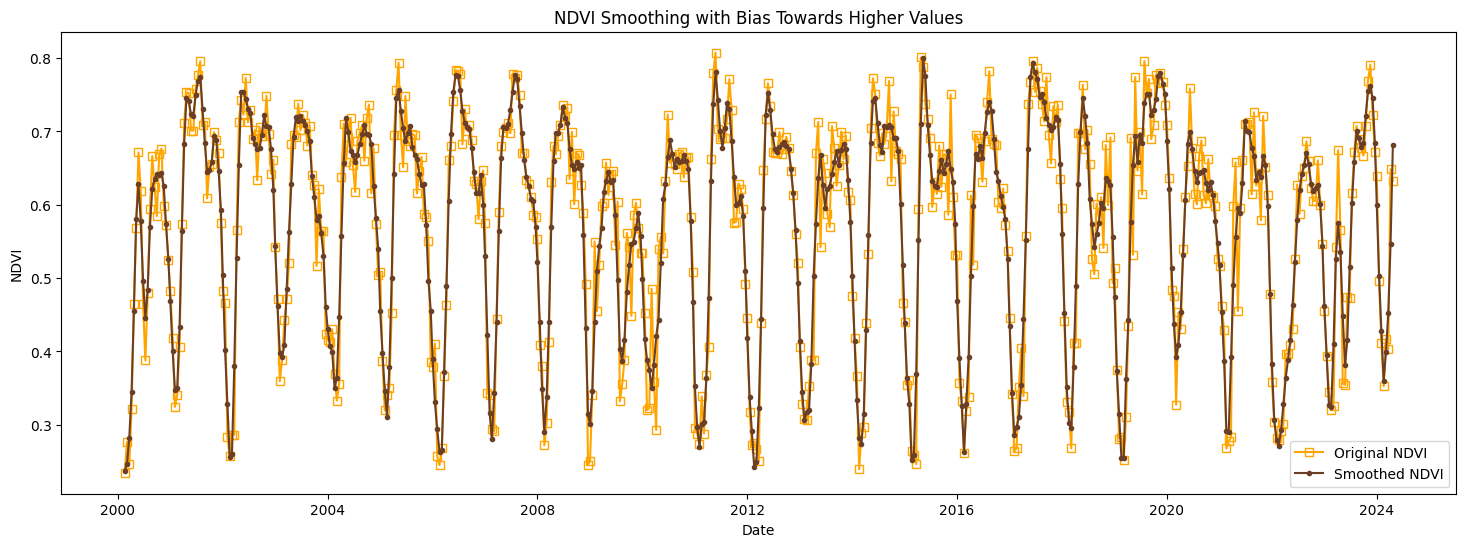

In [17]:
ndvi_mod_df['NDVI_mod'] = ndvi_mod_df['NDVI_mod'].interpolate(method='nearest')


window_length = 7  # Window length must be odd
polyorder = 2      # Polynomial order

# Ensure the window length is smaller than the series length
if len(ndvi_mod_df) > window_length:
    # Apply Savitzky-Golay filter to the original data
    ndvi_mod_df['NDVI_mod_smooth'] = savgol_filter(ndvi_mod_df['NDVI_mod'],
                                                   window_length, polyorder)

# Display the result

plt.figure(figsize=(18, 6))
plt.plot(ndvi_mod_df['date'], ndvi_mod_df['NDVI_mod'],
         label='Original NDVI', color='orange',
         marker = 's',markerfacecolor='none')
plt.plot(ndvi_mod_df['date'], ndvi_mod_df['NDVI_mod_smooth'],
         label='Smoothed NDVI', color='#6b3e26',
         marker = 'o', markersize=3)

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Smoothing with Bias Towards Higher Values')
plt.legend()
plt.show()

### Part 3: Productivity Analysis and Environmental Analysis

In this section, we will delve into the analysis of crop productivity and its relationship with environmental factors. We will calculate key productivity metrics, identify trends and anomalies, and perform a comparative analysis on the points were used for data extraction. Then we repeat the data extraction and productivity on two points of interest: one within a refugee area and another slightly distant from it. The analysis will be conducted using both Sentinel-2 and MODIS datasets.

Here is a detailed breakdown of the tasks involved in this part:

1. **Productivity Metrics Calculation:**
   - We calculate crop productivity metrics defined following methods similar to those used in  [TIMESAT](https://web.nateko.lu.se/timesat/timesat.asp).
   - We define the agricultural year from February 10 to the following February 10 to capture seasonality.
   - Extend the search time to ensure the lowest points on either side of the curve are included.
   - Calculate the following metrics for each agricultural year:
     - **NDVI_max:** Maximum NDVI
     - **NDVI_sos:** Start of season NDVI
     - **NDVI_eos:** End of season NDVI
     - **lmin:** Left minimum NDVI
     - **rmin:** Right minimum NDVI
   - Extract the dates of these events to analyze seasonality.

2. **Trend and Anomalies Analysis:**
   - Analyze the trend of crop productivity, precipitation, and temperature over time.
   - Identify the magnitude and years of anomalies in productivity metrics, precipitation, and temperature.

3. **Environmental Analysis:**
   - Investigate the relationship between crop productivity, precipitation, and temperature.
   - Calculate [Killing Degree Days (KDDs)](https://phuybers.sites.fas.harvard.edu/Doc/Butler_NatureCC2013.pdf), a measure of the accumulated effect of high temperatures that may inhibit and damage crop growth.
   - Use scatter plots to visualize the relationships and identify patterns.
   

By following these steps, we will gain a comprehensive understanding of crop productivity dynamics, their environmental drivers, and the impact of specific locations on agricultural outcomes. This analysis will provide valuable insights for agricultural management and policy-making, especially in areas affected by human activities such as refugee settlements.


#### Define functions for Part 3

In [18]:
def custom_year(date):
    if date.month < 2 or (date.month == 2 and date.day < 10):
        return date.year - 1
    else:
        return date.year

def calculate_percentiles(df, ag_year, value_col, onset=0.1, end=0.7,
                          extend_by_months=1):

    group_current_year = df[df['ag_year'] == ag_year]

    start_date = group_current_year['date'].min() - \
            pd.DateOffset(months=extend_by_months)
    end_date = group_current_year['date'].max() + \
            pd.DateOffset(months=extend_by_months)

    group_extended = df[(df['date'] >= start_date) & (df['date'] <= end_date)]


    if group_extended[value_col].isna().any():

        warnings.warn("Not enough data for the extending search" \
                      " in agriculture year {}".format(ag_year))
        return pd.Series({
        'NDVI_max': np.nan,
        'NDVI_max_date': np.nan,
        'NDVI_lmin': np.nan,
        'NDVI_lmin_date': np.nan,
        'NDVI_rmin': np.nan,
        'NDVI_rmin_date': np.nan,
        'NDVI_sos': np.nan,
        'NDVI_sos_date': np.nan,
        'NDVI_eos': np.nan,
        'NDVI_eos_date': np.nan
        })

    # we still use un-extended data for searching max.
    ndvi_max = group_current_year[value_col].max()
    # return the first date of max if two max exist

    max_date = group_current_year[group_extended[value_col] == \
                                  ndvi_max]['date'].iloc[0]
    group_greenup = group_extended[group_extended['date'] < max_date]
    group_greendown = group_extended[group_extended['date'] > max_date]

    ndvi_t0 = group_greenup[value_col].min()


    ndvi_t0_date =  group_greenup[group_greenup[value_col] == \
                                  ndvi_t0]['date'].iloc[0]

    ndvi_te = group_greendown[value_col].min()
    ndvi_te_date =  group_greendown[group_greendown[value_col] == \
                                    ndvi_te]['date'].iloc[0]

    delta_up = ndvi_max - ndvi_t0
    delta_down = ndvi_max - ndvi_te

    # start and end of season
    ndvi_sos = ndvi_t0 + delta_up * onset
    ndvi_eos = ndvi_max - delta_down * end

    ndvi_sos_date = group_greenup.loc[(group_greenup[value_col] - \
                                       ndvi_sos).abs().idxmin(), 'date']
    ndvi_eos_date = group_greendown.loc[(group_greendown[value_col] - \
                                         ndvi_eos).abs().idxmin(), 'date']

    return pd.Series({
        'NDVI_max': ndvi_max,
        'NDVI_max_date': max_date,
        'NDVI_lmin': ndvi_t0,
        'NDVI_lmin_date': ndvi_t0_date,
        'NDVI_rmin': ndvi_te,
        'NDVI_rmin_date': ndvi_te_date,
        'NDVI_sos': ndvi_sos,
        'NDVI_sos_date': ndvi_sos_date,
        'NDVI_eos': ndvi_eos,
        'NDVI_eos_date': ndvi_eos_date
    })


def calculate_seasonal_integral(phenology_metrics, df,value_col):
    # Creating a mask for the date range specified in phenology_metrics

    phenology_metrics['NDVI_sos_date'] = pd.to_datetime(
        phenology_metrics['NDVI_sos_date']
    )
    phenology_metrics['NDVI_eos_date'] = pd.to_datetime(
        phenology_metrics['NDVI_eos_date']
    )

    mask = (df['date'] > phenology_metrics['NDVI_sos_date']) & \
     (df['date'] < phenology_metrics['NDVI_eos_date'])

    # Extracting the relevant subset of the dataframe
    subset_df = df[mask]

    # Perform trapezoidal integration over the 'NDVI_s2_weighted_smooth' column
    integral_value = trapz(subset_df[value_col], \
                           subset_df['date'].map(pd.Timestamp.toordinal))

    return integral_value

def killing_degree_days(df, threshold = 35):
    df['KDD'] = df['temperature'].apply(
        lambda x: x - threshold if x > threshold else 0
    )
    kdd = df.groupby(['ag_year', 'id'])['KDD'].sum().reset_index()

    return kdd

#### Calculate productivity metrics for Sentinel-2

In [19]:
# Initialize empty lists to store results
# Apply the custom year function
ndvi_s2_df['ag_year'] = ndvi_s2_df['date'].apply(custom_year)
ndvi_s2_df = ndvi_s2_df[
    (ndvi_s2_df['ag_year'] < 2024) & (ndvi_s2_df['ag_year'] >2018)
]


s2_ag_years = []
s2_phenologies_list = []
s2_annual_integrals = []
s2_seasonal_integrals = []

# Iterate through each agricultural year and calculate percentiles and integrals
for ag_year in ndvi_s2_df['ag_year'].unique():
    s2_ag_years.append(ag_year)
    phenologies = calculate_percentiles(ndvi_s2_df, ag_year, \
                                        'NDVI_s2_weighted_smooth')
    seasonal_integral = calculate_seasonal_integral(phenologies, ndvi_s2_df,
                                                    'NDVI_s2_weighted_smooth')

    s2_seasonal_integrals.append(seasonal_integral)
    s2_phenologies_list.append(phenologies)


s2_phenologies_df = pd.DataFrame(s2_phenologies_list)
s2_annual_summary_df = pd.DataFrame({
        'ag_year': s2_ag_years,
        'NDVI_max': s2_phenologies_df['NDVI_max'].values,
        'NDVI_max_date': s2_phenologies_df['NDVI_max_date'].values,
        'NDVI_lmin': s2_phenologies_df['NDVI_lmin'].values,
        'NDVI_lmin_date': s2_phenologies_df['NDVI_lmin_date'].values,
        'NDVI_rmin': s2_phenologies_df['NDVI_rmin'].values,
        'NDVI_rmin_date': s2_phenologies_df['NDVI_rmin_date'].values,
        'NDVI_sos': s2_phenologies_df['NDVI_sos'].values,
        'NDVI_sos_date': s2_phenologies_df['NDVI_sos_date'].values,
        'NDVI_eos': s2_phenologies_df['NDVI_eos'].values,
        'NDVI_eos_date': s2_phenologies_df['NDVI_eos_date'].values,
        'NDVI_seasonal_integral':s2_seasonal_integrals
        })
s2_annual_summary_df = s2_annual_summary_df.dropna()
s2_annual_summary_df


ag_year  NDVI_max NDVI_max_date  NDVI_lmin NDVI_lmin_date  NDVI_rmin  \
0     2019  0.845004    2019-09-02   0.204461     2019-02-22   0.473629   
1     2020  0.686414    2020-10-21   0.343135     2020-04-07   0.219288   
2     2021  0.719698    2021-10-09   0.219288     2021-03-08   0.187169   
3     2022  0.693656    2022-10-24   0.187169     2022-02-13   0.296359   
4     2023  0.775400    2023-09-21   0.274444     2023-05-24   0.437003   

  NDVI_rmin_date  NDVI_sos NDVI_sos_date  NDVI_eos NDVI_eos_date  \
0     2020-03-05  0.268515    2019-04-23  0.585042    2020-02-07   
1     2021-03-08  0.377463    2020-05-04  0.359426    2021-02-03   
2     2022-02-13  0.269329    2021-03-15  0.346928    2022-01-12   
3     2023-02-16  0.237818    2022-04-07  0.415548    2023-01-12   
4     2024-02-08  0.324539    2023-02-08  0.538523    2024-01-12   

   NDVI_seasonal_integral  
0              192.026319  
1              150.762569  
2              152.634622  
3              148.596344  
4              173.192111

#### Calculate productivity metrics for MODIS

In [20]:
ndvi_mod_df['ag_year'] = ndvi_mod_df['date'].apply(custom_year)
ndvi_mod_df = ndvi_mod_df[ndvi_mod_df['ag_year'] < 2024]
# Initialize empty lists to store results
mod_ag_years = []
mod_phenologies_list = []
mod_annual_integrals = []
mod_seasonal_integrals = []

# Iterate through each agricultural year and calculate percentiles and integrals
for ag_year in ndvi_mod_df['ag_year'].unique():

    mod_ag_years.append(ag_year)
    phenologies = calculate_percentiles(ndvi_mod_df, ag_year, 'NDVI_mod_smooth')


    seasonal_integral = calculate_seasonal_integral(phenologies, ndvi_mod_df,
                                                    'NDVI_mod_smooth')

    mod_seasonal_integrals.append(seasonal_integral)
    mod_phenologies_list.append(phenologies)


mod_phenologies_df = pd.DataFrame(mod_phenologies_list)
mod_annual_summary_df = pd.DataFrame({
        'ag_year': mod_ag_years,
        'NDVI_max': mod_phenologies_df['NDVI_max'].values,
        'NDVI_max_date': mod_phenologies_df['NDVI_max_date'].values,
        'NDVI_lmin': mod_phenologies_df['NDVI_lmin'].values,
        'NDVI_lmin_date': mod_phenologies_df['NDVI_lmin_date'].values,
        'NDVI_rmin': mod_phenologies_df['NDVI_rmin'].values,
        'NDVI_rmin_date': mod_phenologies_df['NDVI_rmin_date'].values,
        'NDVI_sos': mod_phenologies_df['NDVI_sos'].values,
        'NDVI_sos_date': mod_phenologies_df['NDVI_sos_date'].values,
        'NDVI_eos': mod_phenologies_df['NDVI_eos'].values,
        'NDVI_eos_date': mod_phenologies_df['NDVI_eos_date'].values,
        'NDVI_seasonal_integral':mod_seasonal_integrals
        })

mod_annual_summary_df = mod_annual_summary_df[
    mod_annual_summary_df['ag_year'] > 2000
]
mod_annual_summary_df

ag_year  NDVI_max NDVI_max_date  NDVI_lmin NDVI_lmin_date  NDVI_rmin  \
1      2001  0.774843    2001-07-28   0.347310     2001-02-02   0.256233   
2      2002  0.754324    2002-05-25   0.256233     2002-02-18   0.392043   
3      2003  0.720829    2003-06-26   0.392043     2003-02-18   0.350152   
4      2004  0.717910    2004-05-08   0.350152     2004-02-18   0.309957   
5      2005  0.757200    2005-05-09   0.309957     2005-02-18   0.262824   
6      2006  0.777195    2006-06-10   0.262824     2006-02-18   0.279919   
7      2007  0.777405    2007-07-28   0.279919     2007-02-18   0.290090   
8      2008  0.733452    2008-06-25   0.290090     2008-02-18   0.300314   
9      2009  0.645319    2009-05-09   0.440005     2009-02-02   0.374767   
10     2010  0.687862    2010-07-12   0.349400     2010-03-06   0.270210   
11     2011  0.781262    2011-05-25   0.270210     2011-02-02   0.242510   
12     2012  0.753067    2012-05-24   0.242510     2012-02-18   0.305752   
13     2013  0.683510    2013-11-01   0.305752     2013-02-02   0.281838   
14     2014  0.745443    2014-06-10   0.273781     2014-03-06   0.252238   
15     2015  0.800286    2015-05-09   0.252238     2015-02-18   0.263062   
16     2016  0.739824    2016-08-12   0.263062     2016-02-18   0.286305   
17     2017  0.792776    2017-06-10   0.286305     2017-02-02   0.302829   
18     2018  0.745390    2018-05-25   0.295419     2018-03-06   0.254476   
19     2019  0.779271    2019-11-17   0.254476     2019-02-18   0.437324   
20     2020  0.699552    2020-06-09   0.393014     2020-03-05   0.291019   
21     2021  0.714143    2021-06-26   0.289805     2021-03-06   0.271519   
22     2022  0.670019    2022-08-29   0.271519     2022-02-18   0.324567   
23     2023  0.762443    2023-11-17   0.324567     2023-02-18   0.427814   

   NDVI_rmin_date  NDVI_sos NDVI_sos_date  NDVI_eos NDVI_eos_date  \
1      2002-02-18  0.390063    2001-02-18  0.411816    2002-01-17   
2      2003-02-18  0.306042    2002-02-02  0.500727    2003-01-17   
3      2004-02-18  0.424921    2003-03-06  0.461355    2003-12-19   
4      2005-02-18  0.386928    2004-02-02  0.432343    2005-01-01   
5      2006-02-18  0.354681    2005-02-02  0.411137    2006-01-01   
6      2007-02-18  0.314261    2006-02-02  0.429102    2007-01-17   
7      2008-02-18  0.329668    2007-03-06  0.436285    2008-01-17   
8      2009-01-01  0.334427    2008-03-05  0.430256    2008-12-02   
9      2010-02-18  0.460536    2009-02-02  0.455932    2009-09-14   
10     2011-02-02  0.383246    2010-03-22  0.395505    2011-01-01   
11     2012-02-18  0.321315    2011-03-06  0.404135    2012-01-01   
12     2013-02-02  0.293565    2012-02-02  0.439947    2013-01-01   
13     2014-02-18  0.343528    2013-03-06  0.402340    2014-01-17   
14     2015-02-18  0.320947    2014-03-22  0.400200    2015-01-17   
15     2016-02-18  0.307043    2015-02-02  0.424229    2016-01-17   
16     2017-02-02  0.310738    2016-02-02  0.422360    2017-01-01   
17     2018-02-18  0.336952    2017-03-22  0.449813    2018-01-17   
18     2019-02-18  0.340416    2018-02-02  0.401750    2019-01-17   
19     2020-02-18  0.306956    2019-02-02  0.539908    2020-02-02   
20     2021-02-18  0.423668    2020-02-18  0.413579    2021-02-02   
21     2022-02-18  0.332239    2021-02-18  0.404306    2022-01-01   
22     2023-02-18  0.311369    2022-03-22  0.428202    2023-01-17   
23     2024-02-02  0.368354    2023-05-25  0.528203    2024-01-17   

    NDVI_seasonal_integral  
1               205.188340  
2               202.788755  
3               165.324381  
4               190.776267  
5               190.471581  
6               198.776143  
7               190.394538  
8               159.041486  
9               105.719429  
10              157.680648  
11              177.298171  
12              183.383886  
13              177.053614  
14              178.264243  
15              193.922969  
16              184.623848  
17              190.369976  


#### Relating Cropland Productivity Metrics to Annual Precipitation and Temperature

We first plot the productivity metrics and visually examine if there is a long-term trend. If a long-term trend is prominent, it is necessary to detrend the data to separate the short-term variations when conducting the correlation analysis. We assume Sentinel-2 data won't show a long-term trend as it has a relatively short record. For MODIS, there is more than 20 years of data, but this may still not be long enough to capture climate change effects or technological improvements.


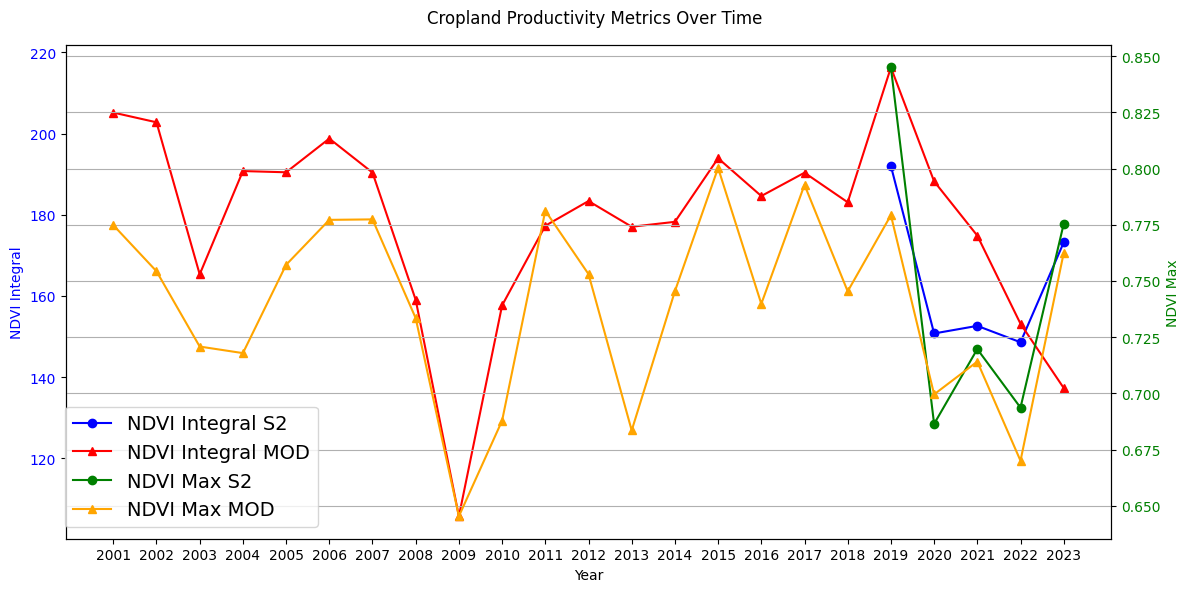

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))


# Plot NDVI integral with different markers and colors
ax1.plot(s2_annual_summary_df['ag_year'],
         s2_annual_summary_df['NDVI_seasonal_integral'], marker='o',
         linestyle='-', color='blue', label='NDVI Integral S2')
ax1.plot(mod_annual_summary_df['ag_year'], \
         mod_annual_summary_df['NDVI_seasonal_integral'], marker='^',
         linestyle='-', color='red', label='NDVI Integral MOD')
ax1.set_xlabel('Year')
ax1.set_ylabel('NDVI Integral', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
years = mod_annual_summary_df['ag_year'].tolist()
ax1.set_xticks(years)

# Create a second y-axis for NDVI max
ax2 = ax1.twinx()
ax2.plot(s2_annual_summary_df['ag_year'], s2_annual_summary_df['NDVI_max'],
         marker='o', linestyle='-', color='green', label='NDVI Max S2')
ax2.plot(mod_annual_summary_df['ag_year'], mod_annual_summary_df['NDVI_max'],
         marker='^', linestyle='-', color='orange', label='NDVI Max MOD')
ax2.set_ylabel('NDVI Max', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# Title and legends
fig.suptitle('Cropland Productivity Metrics Over Time')
fig.legend(loc='lower left', fontsize=14, bbox_to_anchor=(0.05, 0.1))
plt.grid(True)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


We do see variations in crop productivity as captured by both MODIS and Sentinel-2. In 2009, both the maximum NDVI and the NDVI integral suggest a dip in productivity. In 2013, MODIS showed a decrease in maximum NDVI but not in the seasonal NDVI integral. Similarly, in both 2020 and 2022, data from MODIS and Sentinel-2 indicate a decrease as well. However, the long-term trend of productivity does not appear very prominent in the MODIS data. Let's see what the detrending analysis shows.

##### Detrending Analysis

We will calculate the detrended values for annual crop productivity, precipitation, and temperature.

Note: For precipitation data, we download it as annual totals. However, temperature data are recorded daily. We'll use some of the techniques you just learned in the previous section to process these daily temperatures. This includes gap-filling, assigning agricultural years, and summarizing to calculate an annual mean daily temperature. We'll also retain the daily temperature data for later use, specifically for calculating Killing Degree Days (KDDs).


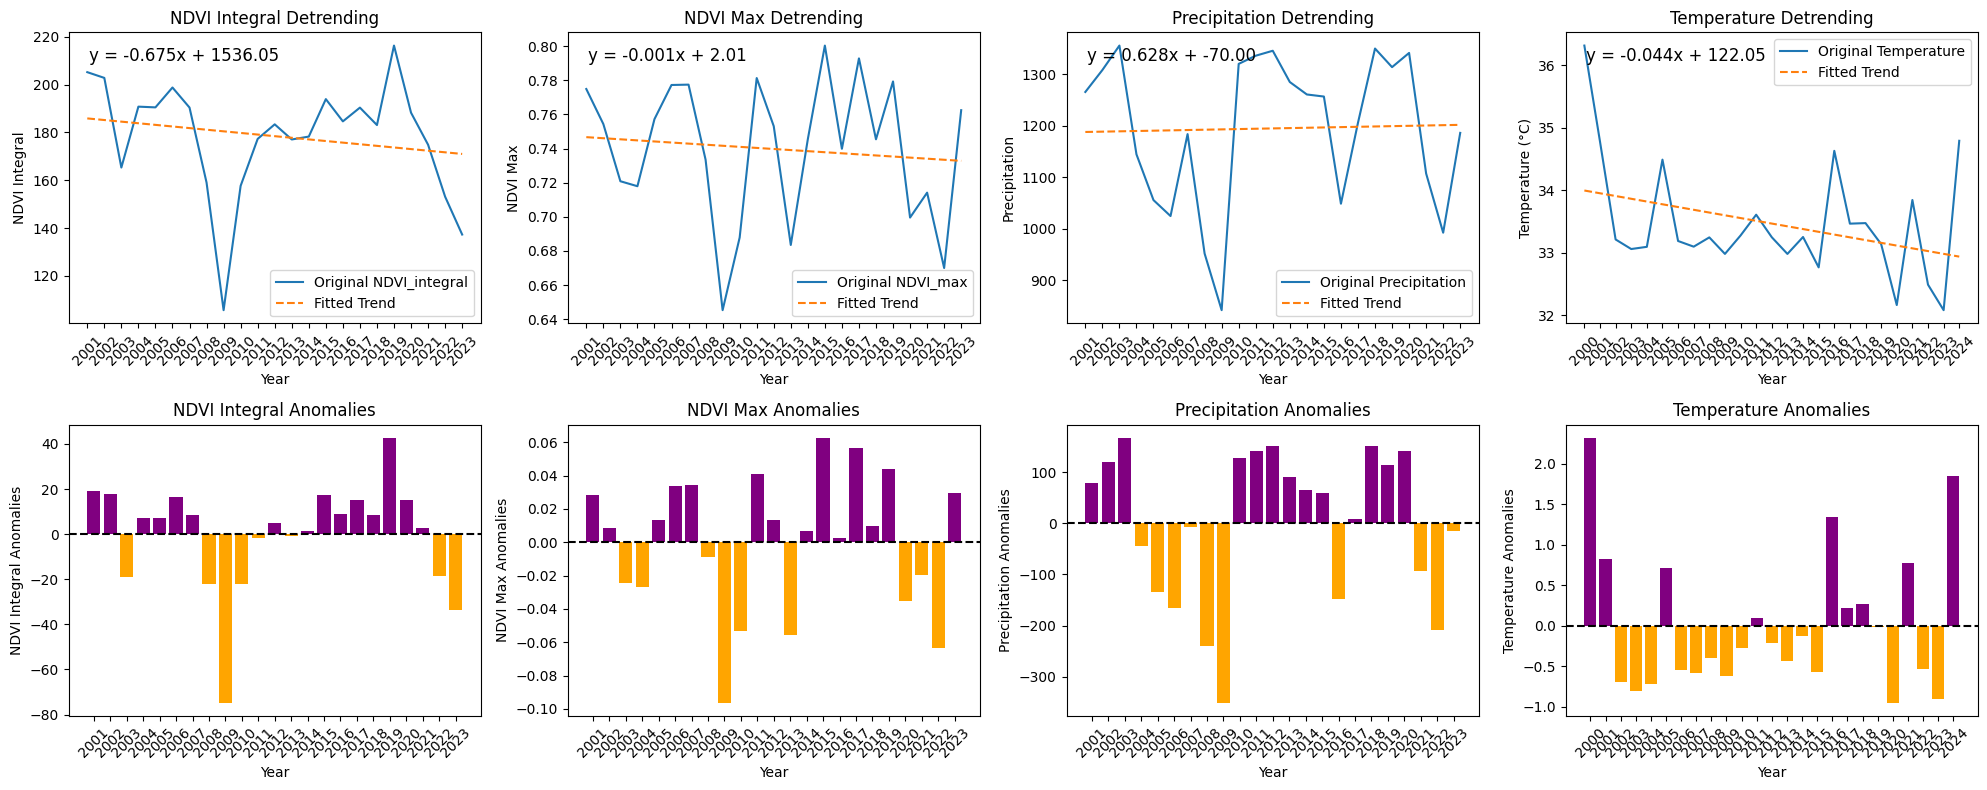

In [24]:
# Detrending function
def detrend(series, x):
    X = x.values.reshape(-1, 1)
    y = series.values
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    detrended = y - trend
    return model, trend, detrended

# Add equation text function
def add_equation(ax, model, x):
    m = model.coef_[0]
    b = model.intercept_
    equation_text = f'y = {m:.3f}x + {b:.2f}'
    ax.text(0.05, 0.95, equation_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top')

# Detrend NDVI_integral
model_ndvi_integral, trend_ndvi_integral, detrended_ndvi_integral = \
        detrend(mod_annual_summary_df['NDVI_seasonal_integral'],
                mod_annual_summary_df['ag_year'])
mod_annual_summary_df['NDVI_detrended_integral'] = detrended_ndvi_integral

# Detrend NDVI_max
model_ndvi_max, trend_ndvi_max, detrended_ndvi_max = \
        detrend(mod_annual_summary_df['NDVI_max'],
                mod_annual_summary_df['ag_year'])
mod_annual_summary_df['NDVI_detrended_max'] = detrended_ndvi_max

# Detrend precipitation
precip_df['ag_year'] = precip_df['date'].apply(custom_year)
precip_df = precip_df[
    (precip_df['ag_year'] > 2000) & (precip_df['ag_year'] < 2024)
]
model_precip, trend_precip, detrended_precip = \
        detrend(precip_df['annual_precipitation'], precip_df['ag_year'])
precip_df['precip_detrended'] = detrended_precip

# Detrend temperature
annual_lst_df = lst_df.copy()
annual_lst_df['ag_year'] = annual_lst_df['date'].apply(custom_year)
annual_lst_df['temperature'] = annual_lst_df['temperature']\
    .ffill().bfill().interpolate(method='linear')
annual_lst_df = annual_lst_df.groupby('ag_year')['temperature']\
    .mean().reset_index()
model_temp, trend_temp, detrended_temp = detrend(
    annual_lst_df['temperature'], annual_lst_df['ag_year']
)
annual_lst_df['temperature_detrended'] = detrended_temp

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

years = mod_annual_summary_df['ag_year'].unique()
precip_years = precip_df['ag_year'].unique()
temp_years = annual_lst_df['ag_year'].unique()



# Plot NDVI_integral and its trend
ax1 = axs[0, 0]
ax1.plot(mod_annual_summary_df['ag_year'],
         mod_annual_summary_df['NDVI_seasonal_integral'],
         label='Original NDVI_integral')
ax1.plot(mod_annual_summary_df['ag_year'], trend_ndvi_integral,
         label='Fitted Trend', linestyle='--')
add_equation(ax1, model_ndvi_integral, mod_annual_summary_df['ag_year'])
ax1.set_xlabel('Year')
ax1.set_ylabel('NDVI Integral')
ax1.legend()
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)
ax1.set_title('NDVI Integral Detrending')

# Plot NDVI_max and its trend
ax2 = axs[0, 1]
ax2.plot(mod_annual_summary_df['ag_year'],
         mod_annual_summary_df['NDVI_max'], label='Original NDVI_max')
ax2.plot(mod_annual_summary_df['ag_year'], trend_ndvi_max,
         label='Fitted Trend', linestyle='--')
add_equation(ax2, model_ndvi_max, mod_annual_summary_df['ag_year'])
ax2.set_xlabel('Year')
ax2.set_ylabel('NDVI Max')
ax2.legend()
ax2.set_xticks(years)
ax2.set_xticklabels(years, rotation=45)
ax2.set_title('NDVI Max Detrending')

# Plot precipitation and its trend
ax3 = axs[0, 2]
ax3.plot(precip_df['ag_year'], precip_df['annual_precipitation'], \
         label='Original Precipitation')
ax3.plot(precip_df['ag_year'], trend_precip, label='Fitted Trend',
         linestyle='--')
add_equation(ax3, model_precip, precip_df['ag_year'])
ax3.set_xlabel('Year')
ax3.set_ylabel('Precipitation')
ax3.legend()
ax3.set_title('Precipitation Detrending')
ax3.set_xticks(precip_years)
ax3.set_xticklabels(precip_years, rotation=45)

# Plot temperature and its trend
ax4 = axs[0, 3]
ax4.plot(annual_lst_df['ag_year'], annual_lst_df['temperature'],
         label='Original Temperature')
ax4.plot(annual_lst_df['ag_year'], trend_temp, label='Fitted Trend',
         linestyle='--')
add_equation(ax4, model_temp, annual_lst_df['ag_year'])
ax4.set_xlabel('Year')
ax4.set_ylabel('Temperature (°C)')
ax4.legend()
ax4.set_xticks(temp_years)
ax4.set_xticklabels(temp_years, rotation=45)
ax4.set_title('Temperature Detrending')


# Plot NDVI_integral anomalies
ax5 = axs[1, 0]
colors_integral = np.where(
    mod_annual_summary_df['NDVI_detrended_integral'] > 0, 'purple', 'orange'
)
ax5.bar(mod_annual_summary_df['ag_year'],
        mod_annual_summary_df['NDVI_detrended_integral'],
        color=colors_integral)
ax5.axhline(0, color='black', linestyle='--')
ax5.set_xlabel('Year')
ax5.set_ylabel('NDVI Integral Anomalies')
ax5.set_xticks(years)
ax5.set_xticklabels(years, rotation=45)
ax5.set_title('NDVI Integral Anomalies')

# Plot NDVI_max anomalies
ax6 = axs[1, 1]
colors_max = np.where(mod_annual_summary_df['NDVI_detrended_max'] > 0,
                      'purple', 'orange')
ax6.bar(mod_annual_summary_df['ag_year'], \
        mod_annual_summary_df['NDVI_detrended_max'], color=colors_max)
ax6.axhline(0, color='black', linestyle='--')
ax6.set_xlabel('Year')
ax6.set_ylabel('NDVI Max Anomalies')
ax6.set_xticks(years)
ax6.set_xticklabels(years, rotation=45)
ax6.set_title('NDVI Max Anomalies')

# Plot precipitation anomalies
ax7 = axs[1, 2]
colors_precip = np.where(precip_df['precip_detrended'] > 0, 'purple', 'orange')
ax7.bar(precip_df['ag_year'], precip_df['precip_detrended'],
        color=colors_precip)
ax7.axhline(0, color='black', linestyle='--')
ax7.set_xlabel('Year')
ax7.set_ylabel('Precipitation Anomalies')
ax7.set_title('Precipitation Anomalies')
ax7.set_xticks(precip_years)
ax7.set_xticklabels(precip_years, rotation=45)

# Plot temperature anomalies
ax8 = axs[1, 3]
colors_temp = np.where(annual_lst_df['temperature_detrended'] > 0,
                       'purple', 'orange')
ax8.bar(annual_lst_df['ag_year'], annual_lst_df['temperature_detrended'],
        color=colors_temp)
ax8.axhline(0, color='black', linestyle='--')
ax8.set_xlabel('Year')
ax8.set_ylabel('Temperature Anomalies')
ax8.set_xticks(annual_lst_df['ag_year'].unique())
ax8.set_xticklabels(annual_lst_df['ag_year'].unique(), rotation=45)
ax8.set_title('Temperature Anomalies')

# Adjust layout
plt.tight_layout()
plt.show()

How would you describe the trend in crop productivity, precipitation, and temperature? It seems that crop productivity is declining, though not drastically. For instance, the NDVI max shows a trend with a slope of -0.001, meaning it decreases by -0.001 each year, based on the fitted line. Precipitation varies between 1000mm and 1300mm, with noticeable drops in years like 2004-2009, 2016, and 2022. As for temperature, it appears to be decreasing by 0.044 degrees per year. However, year 2000 might be an outlier, and the slope would likely be flatter if we removed this year from our analysis. However, since 2016, temperature has shown higher variability.

##### Assessing the Relationship Between Precipitation and Crop Productivity

First, we'll explore the relationship between precipitation and crop productivity by examining the raw data.

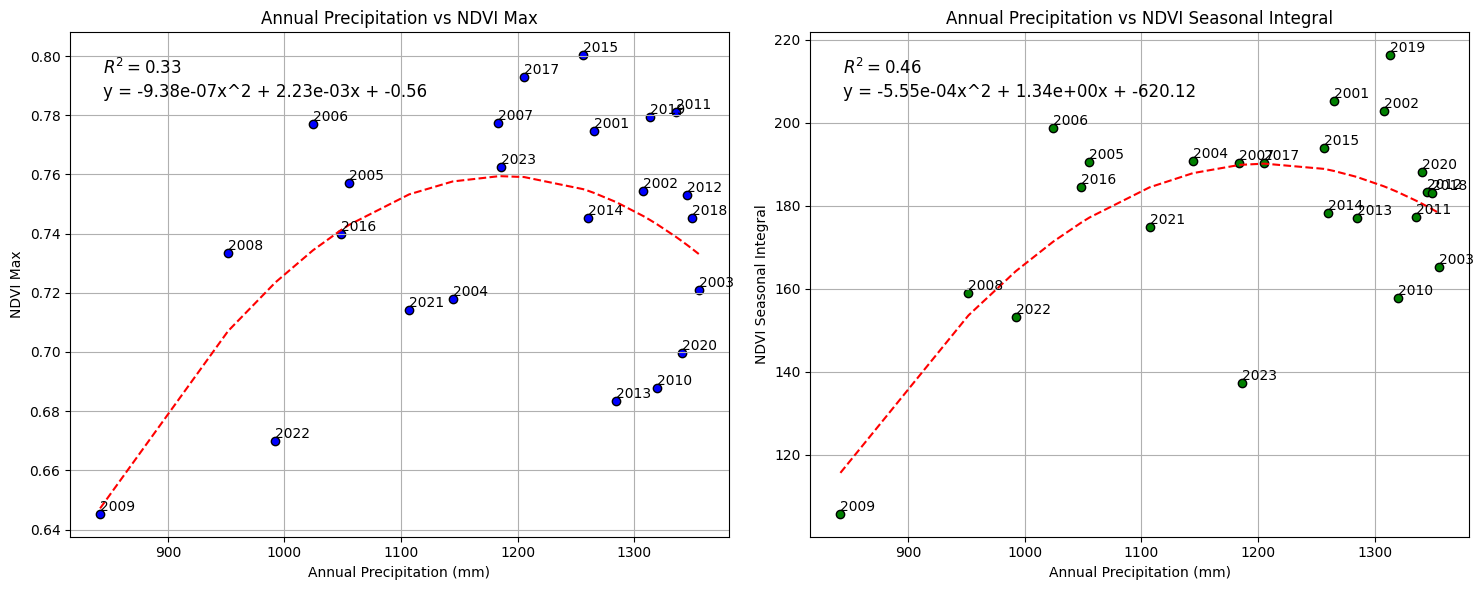

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Annual Precipitation vs NDVI Max
x1 = precip_df['annual_precipitation']
y1 = mod_annual_summary_df['NDVI_max']
ax1.scatter(x1, y1, color='blue', edgecolor='k')

# Polynomial fit for the first subplot
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
y1_pred = p1(np.sort(x1))
r2_1 = r2_score(y1, p1(x1))

ax1.plot(np.sort(x1), y1_pred, "r--")

for x, y, year in zip(x1, y1, mod_annual_summary_df['ag_year']):
    ax1.text(x, y, f'{year}', ha='left', va='bottom')
ax1.set_title('Annual Precipitation vs NDVI Max')
ax1.set_xlabel('Annual Precipitation (mm)')
ax1.set_ylabel('NDVI Max')
ax1.text(0.05, 0.95, f'$R^2 = {r2_1:.2f}$', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
equation1 = f'y = {z1[0]:.2e}x^2 + {z1[1]:.2e}x + {z1[2]:.2f}'
ax1.text(0.05, 0.90, equation1, transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
ax1.grid(True)

# Second subplot: Annual Precipitation vs NDVI Seasonal Integral
x2 = precip_df['annual_precipitation']
y2 = mod_annual_summary_df['NDVI_seasonal_integral']
ax2.scatter(x2, y2, color='green', edgecolor='k')

# Polynomial fit for the second subplot
z2 = np.polyfit(x2, y2, 2)
p2 = np.poly1d(z2)
y2_pred = p2(np.sort(x2))
r2_2 = r2_score(y2, p2(x2))

ax2.plot(np.sort(x2), y2_pred, "r--")

for x, y, year in zip(x2, y2, mod_annual_summary_df['ag_year']):
    ax2.text(x, y, f'{year}', ha='left', va='bottom')
ax2.set_title('Annual Precipitation vs NDVI Seasonal Integral')
ax2.set_xlabel('Annual Precipitation (mm)')
ax2.set_ylabel('NDVI Seasonal Integral')
ax2.text(0.05, 0.95, f'$R^2 = {r2_2:.2f}$', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
equation2 = f'y = {z2[0]:.2e}x^2 + {z2[1]:.2e}x + {z2[2]:.2f}'
ax2.text(0.05, 0.90, equation2, transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
ax2.grid(True)

plt.tight_layout()
plt.show()

Now, let's take a look at the precipitation anomalies and crop productivity anomalies, after removing their long-term trends.

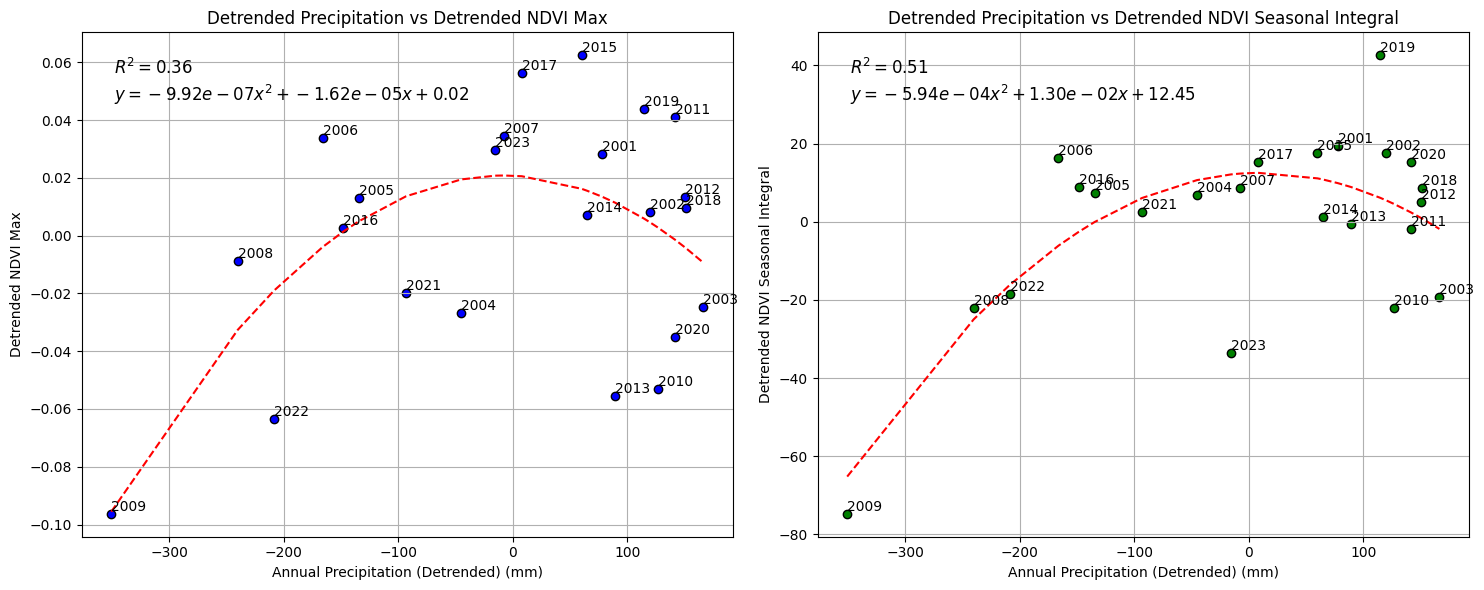

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Annual Precipitation vs NDVI Max
x1 = precip_df['precip_detrended']
y1 = mod_annual_summary_df['NDVI_detrended_max']
ax1.scatter(x1, y1, color='blue', edgecolor='k')

# Polynomial fit for the first subplot
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
y1_pred = p1(np.sort(x1))
r2_1 = r2_score(y1, p1(x1))

ax1.plot(np.sort(x1), y1_pred, "r--")

for x, y, year in zip(x1, y1, mod_annual_summary_df['ag_year']):
    ax1.text(x, y, f'{year}', ha='left', va='bottom')
ax1.set_title('Detrended Precipitation vs Detrended NDVI Max')
ax1.set_xlabel('Annual Precipitation (Detrended) (mm)')
ax1.set_ylabel('Detrended NDVI Max')
ax1.text(0.05, 0.95, f'$R^2 = {r2_1:.2f}$', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
equation1 = f'$y = {z1[0]:.2e}x^2 + {z1[1]:.2e}x + {z1[2]:.2f}$'
ax1.text(0.05, 0.90, equation1, transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
ax1.grid(True)

# Second subplot: Annual Precipitation vs NDVI Seasonal Integral
x2 = precip_df['precip_detrended']
y2 = mod_annual_summary_df['NDVI_detrended_integral']
ax2.scatter(x2, y2, color='green', edgecolor='k')

# Polynomial fit for the second subplot
z2 = np.polyfit(x2, y2, 2)
p2 = np.poly1d(z2)
y2_pred = p2(np.sort(x2))
r2_2 = r2_score(y2, p2(x2))

ax2.plot(np.sort(x2), y2_pred, "r--")

for x, y, year in zip(x2, y2, mod_annual_summary_df['ag_year']):
    ax2.text(x, y, f'{year}', ha='left', va='bottom')
ax2.set_title('Detrended Precipitation vs Detrended NDVI Seasonal Integral')
ax2.set_xlabel('Annual Precipitation (Detrended) (mm)')
ax2.set_ylabel('Detrended NDVI Seasonal Integral')
ax2.text(0.05, 0.95, f'$R^2 = {r2_2:.2f}$', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
equation2 = f'$y = {z2[0]:.2e}x^2 + {z2[1]:.2e}x + {z2[2]:.2f}$'
ax2.text(0.05, 0.90, equation2, transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
ax2.grid(True)

plt.tight_layout()
plt.show()

What can you observe from the scatter plots for both raw data and anomalies above? It appears that negative precipitation correlates with decreases in crop productivity, while positive precipitation has a more nuanced impact on crop productivity. This holds true for both raw data and anomalies. This may suggest that less water is detrimental to the crops, yet an abundance of water does not necessarily enhance crop growth at this sample point. Another thing we may learn is that the region might be experiencing both insufficient precipitation (in 2008, 2009, and 2022) and excessive precipitation (in 2003 and 2010) for crop growth.

##### Calculate Killing Degree Days (KDD)

Killing Degree Days (KDD) are calculated as the sum of the differences between the daily temperature and a specified threshold, for all days where the temperature exceeds that threshold. It is very close to a more commonly used concept called Growing Degree Days [(GDDs)](https://www.canr.msu.edu/news/understanding_growing_degree_days). KDD assumes that an accumulation of high temperatures defined by a threshold may inhibit and harm crop growth. For example, using a threshold of 29°C, the KDD for a given day is calculated as (temperature - 29) if the temperature is greater than 29°C; otherwise, it is zero. The KDD for a period (e.g., an agricultural year) is the sum of the daily KDD values over that period.

In [30]:
lst_df['temperature'] = lst_df['temperature'].ffill().bfill()\
    .interpolate(method='linear')
lst_df['ag_year'] = lst_df['date'].apply(custom_year)
THRESHOLD = 39
kdd_df = killing_degree_days(lst_df, threshold=THRESHOLD)
kdd_df = kdd_df[(kdd_df['ag_year']>2000) & (kdd_df['ag_year']<2024)]

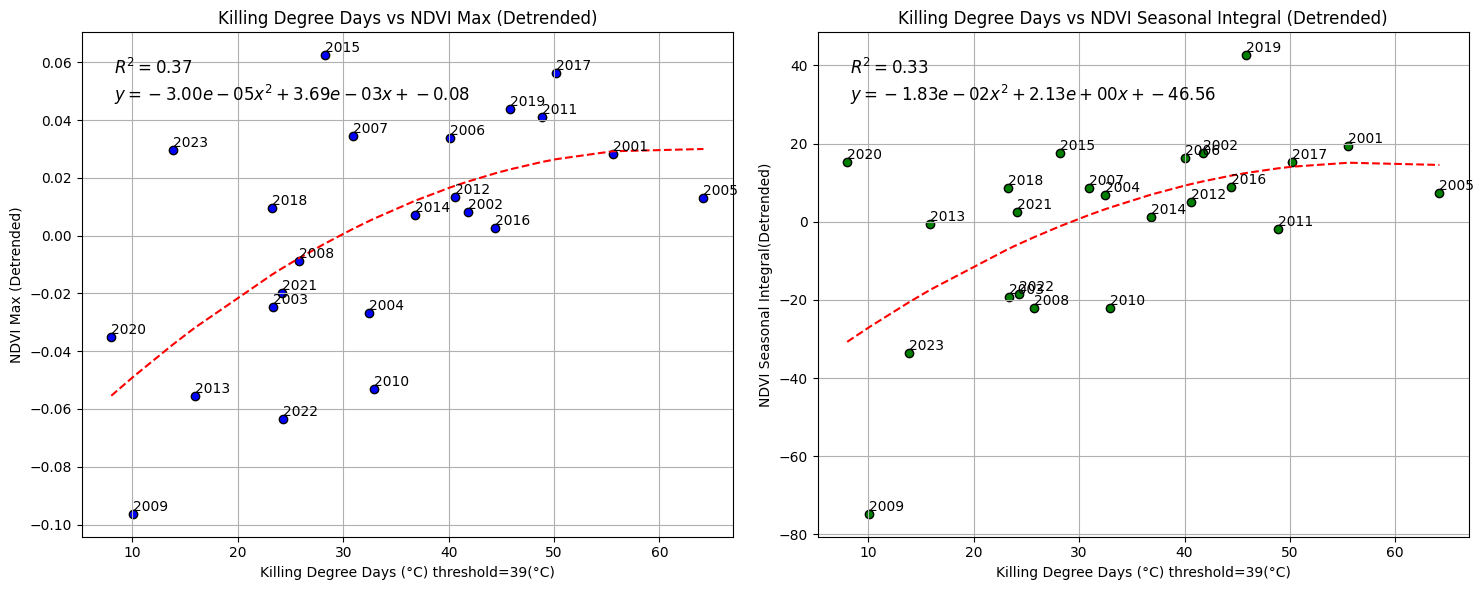

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Killing Degree Days vs NDVI Max
x1 = kdd_df['KDD']
y1 = mod_annual_summary_df['NDVI_detrended_max']
ax1.scatter(x1, y1, color='blue', edgecolor='k')

# Polynomial fit for the first subplot
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
y1_pred = p1(np.sort(x1))
r2_1 = r2_score(y1, p1(x1))

ax1.plot(np.sort(x1), y1_pred, "r--")

for x, y, year in zip(x1, y1, mod_annual_summary_df['ag_year']):
    ax1.text(x, y, f'{year}', ha='left', va='bottom')
ax1.set_title('Killing Degree Days vs NDVI Max (Detrended)')
ax1.set_xlabel('Killing Degree Days (°C) threshold={}(°C)'.format(THRESHOLD))
ax1.set_ylabel('NDVI Max (Detrended)')
ax1.text(0.05, 0.95, f'$R^2 = {r2_1:.2f}$', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
equation1 = f'$y = {z1[0]:.2e}x^2 + {z1[1]:.2e}x + {z1[2]:.2f}$'
ax1.text(0.05, 0.90, equation1, transform=ax1.transAxes,
         fontsize=12, verticalalignment='top')
ax1.grid(True)

# Second subplot: Killing Degree Days vs NDVI Seasonal Integral
x2 = kdd_df['KDD']
y2 = mod_annual_summary_df['NDVI_detrended_integral']
ax2.scatter(x2, y2, color='green', edgecolor='k')

# Polynomial fit for the second subplot
z2 = np.polyfit(x2, y2, 2)
p2 = np.poly1d(z2)
y2_pred = p2(np.sort(x2))
r2_2 = r2_score(y2, p2(x2))

ax2.plot(np.sort(x2), y2_pred, "r--")

for x, y, year in zip(x2, y2, mod_annual_summary_df['ag_year']):
    ax2.text(x, y, f'{year}', ha='left', va='bottom')
ax2.set_title('Killing Degree Days vs NDVI Seasonal Integral (Detrended)')
ax2.set_xlabel('Killing Degree Days (°C) threshold={}(°C)'.format(THRESHOLD))
ax2.set_ylabel('NDVI Seasonal Integral(Detrended)')
ax2.text(0.05, 0.95, f'$R^2 = {r2_2:.2f}$', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
equation2 = f'$y = {z2[0]:.2e}x^2 + {z2[1]:.2e}x + {z2[2]:.2f}$'
ax2.text(0.05, 0.90, equation2, transform=ax2.transAxes,
         fontsize=12, verticalalignment='top')
ax2.grid(True)

plt.tight_layout()
plt.show()

What can you see from the data above? Surprisingly, when temperatures rise above the threshold of 39°C, the resulting killing degree days (KDD) don’t seem to harm crop productivity as much as we might expect, showing a generally positive relationship. However, when KDD accumulates between 40 and 50°C throughout the year, we start to see a decline in crop productivity. It’s important to remember that the impact of these temperatures can vary between different types of crops.

Additionally, the temperature data we used comes from satellite estimates of the land surface, which might not be as accurate as direct measurements from the field and doesn’t directly reflect the air or soil temperatures at root level. Furthermore, the 1 km resolution may not precisely represent the temperature at our specific point of interest.

We also aggregated the temperature data annually and did not split the investigation into different crop growing stages. Our measurements reflect the general vegetative process, while KDDs may have a more significant impact on the reproductive stages that were not captured in the NDVI measurements.

Lastly, consider the year 2001. Despite high temperatures, there was also high precipitation, which might have mitigated the heat stress.

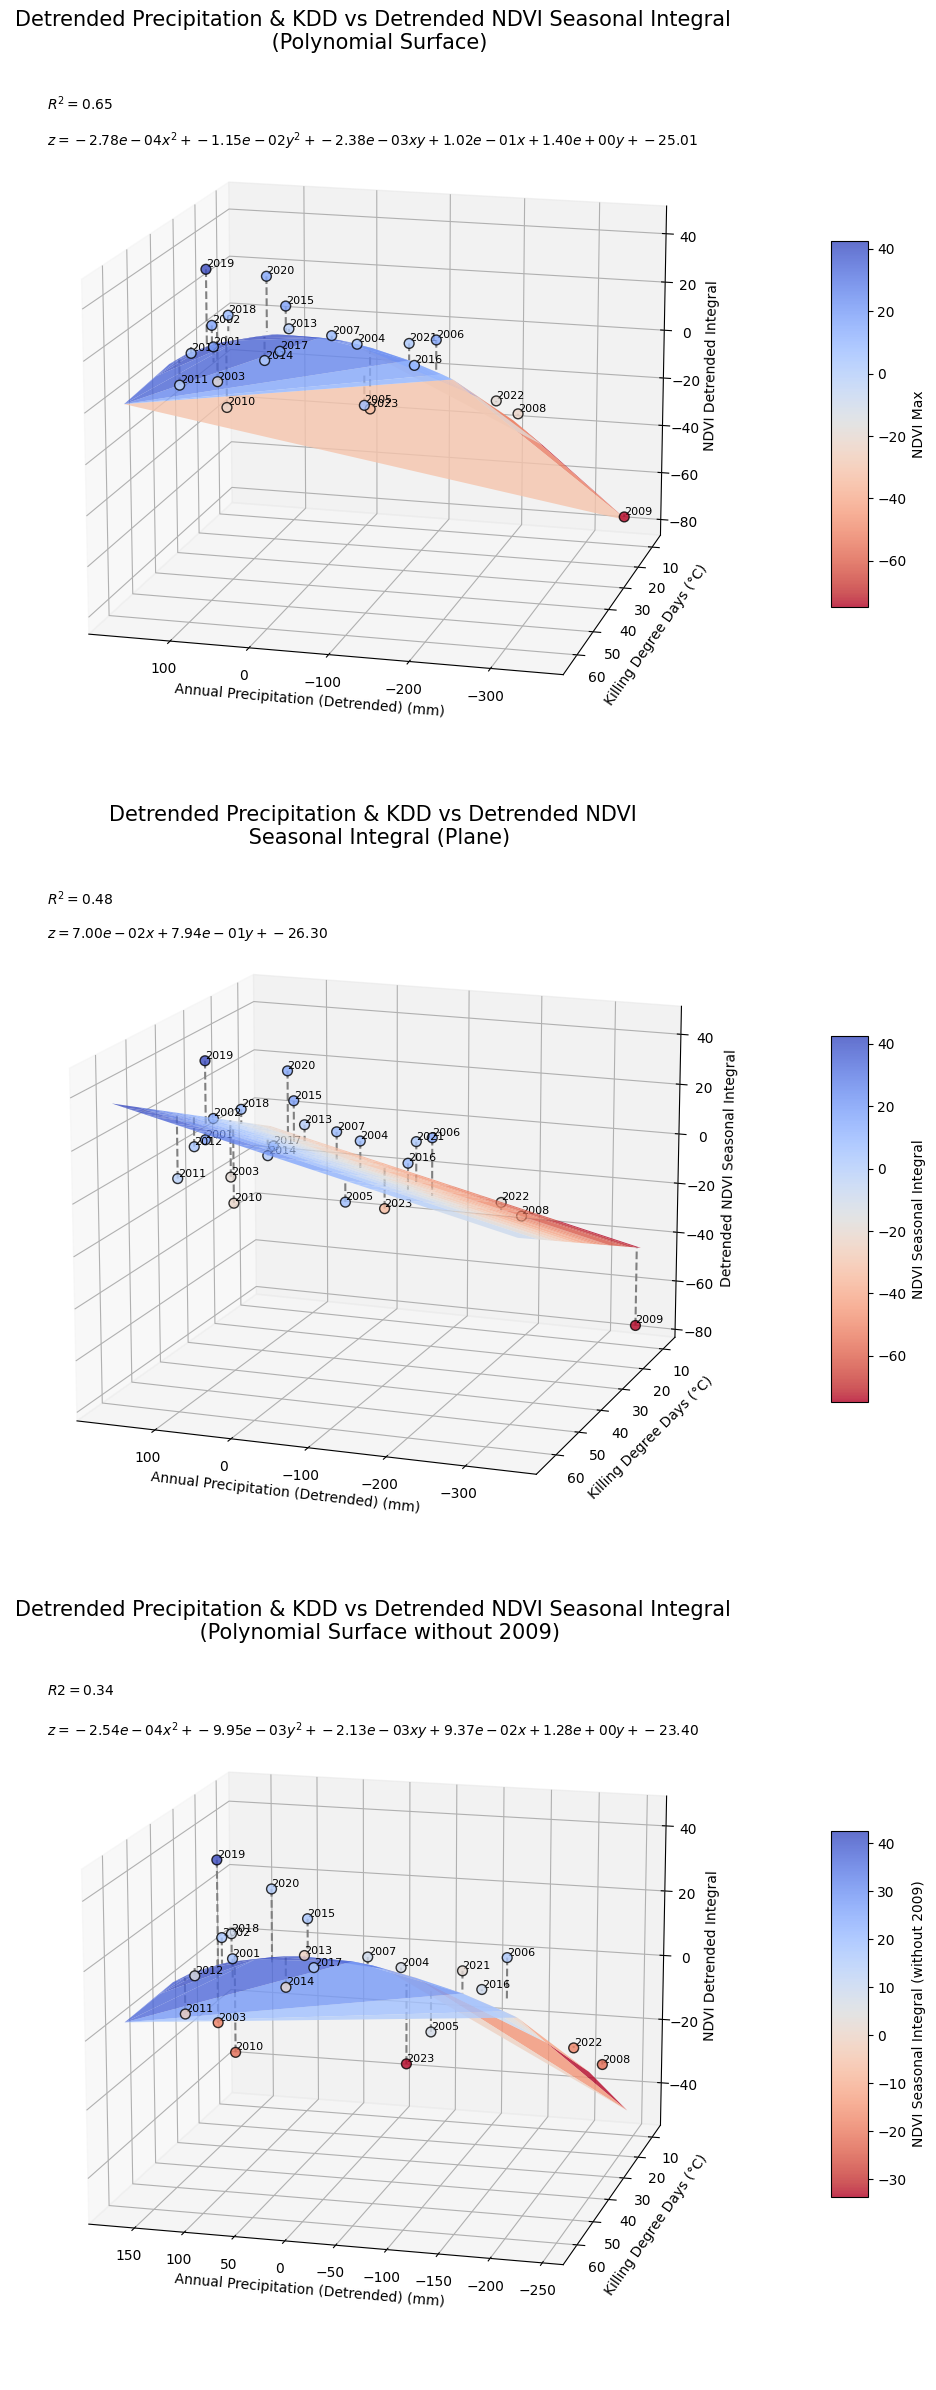

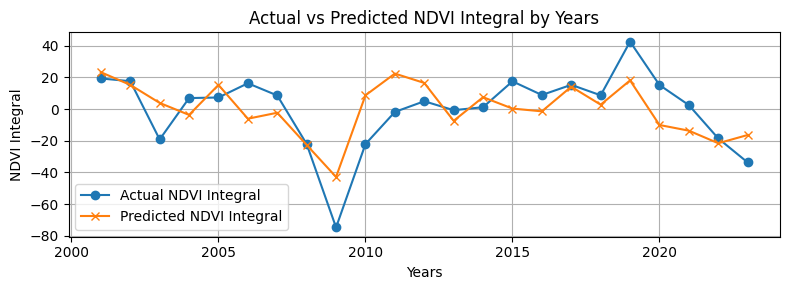

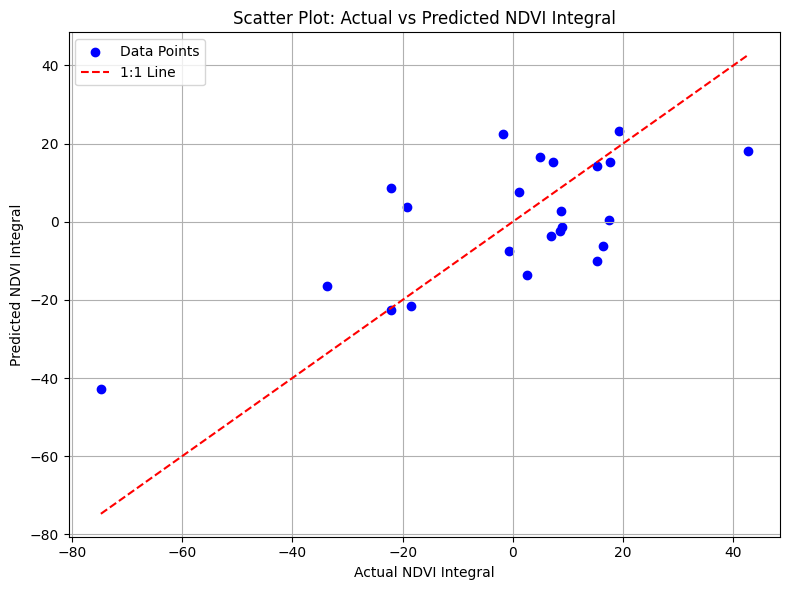

In [34]:
# Helper function to fit polynomial surface
def poly_fit_2d(x, y, z, degree=2):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(np.column_stack([x, y]))
    model = LinearRegression().fit(X_poly, z)
    return model, poly

# Helper function to fit a plane
def plane_fit_2d(x, y, z):
    X = np.column_stack([x, y])
    model = LinearRegression().fit(X, z)
    return model

fig = plt.figure(figsize=(18, 24))

# First 3D subplot (polynomial surface):
# Precipitation vs Killing Degree Days vs Detrended NDVI Seasonal Integral
ax1 = fig.add_subplot(311, projection='3d')
x1 = precip_df['precip_detrended']
y1 = kdd_df['KDD']
z1 = mod_annual_summary_df['NDVI_detrended_integral']
sc1 = ax1.scatter(x1, y1, z1, c=z1, cmap='coolwarm_r', s=50, edgecolor='k', alpha=0.8)

# Polynomial fit for the first subplot
model1, poly1 = poly_fit_2d(x1, y1, z1, degree=2)
X1_pred = poly1.fit_transform(np.column_stack([np.sort(x1), np.sort(y1)]))
z1_pred = model1.predict(X1_pred)
r2_1 = r2_score(z1, model1.predict(poly1.fit_transform(np.column_stack([x1, y1]))))

surface1 = ax1.plot_trisurf(np.sort(x1), np.sort(y1), z1_pred, cmap='coolwarm_r', alpha=0.8)

for x, y, z, year in zip(x1, y1, z1, mod_annual_summary_df['ag_year']):
    ax1.text(x, y, z, f'{year}', ha='left', va='bottom', fontsize=8)
    z_fit = model1.predict(poly1.fit_transform(np.array([[x, y]])))[0]
    ax1.plot([x, x], [y, y], [z, z_fit], color='gray', linestyle='--')

ax1.set_title('Detrended Precipitation & KDD vs Detrended NDVI Seasonal Integral \n (Polynomial Surface)', fontsize=15)
ax1.set_xlabel('Annual Precipitation (Detrended) (mm)', fontsize=10)
ax1.set_ylabel('Killing Degree Days (°C)', fontsize=10)
ax1.set_zlabel('NDVI Detrended Integral', fontsize=10)
ax1.text2D(0.05, 0.95, f'$R^2 = {r2_1:.2f}$', transform=ax1.transAxes, fontsize=10, verticalalignment='top')

# Construct the polynomial equation string
coeff1 = model1.coef_
intercept1 = model1.intercept_
equation1 = (
             f'$z = {coeff1[3]:.2e}x^2 + {coeff1[5]:.2e}y^2 + {coeff1[4]:.2e}xy + {coeff1[1]:.2e}x + {coeff1[2]:.2e}y + {intercept1:.2f}$')
ax1.text2D(0.05, 0.90, equation1, transform=ax1.transAxes, fontsize=10, verticalalignment='top')
ax1.grid(True)

# Second 3D subplot (plane):
# Precipitation vs Killing Degree Days vs NDVI Detrended Integral
ax2 = fig.add_subplot(312, projection='3d')
x2 = precip_df['precip_detrended']
y2 = kdd_df['KDD']
z2 = mod_annual_summary_df['NDVI_detrended_integral']

sc2 = ax2.scatter(x2, y2, z2, c=z2, cmap='coolwarm_r', s=50, edgecolor='k', alpha=0.8)

# Plane fit for the second subplot
model2 = plane_fit_2d(x2, y2, z2)
xx, yy = np.meshgrid(np.sort(x2), np.sort(y2))
zz = model2.predict(np.column_stack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
r2_2 = r2_score(z2, model2.predict(np.column_stack([x2, y2])))

ax2.plot_surface(xx, yy, zz, cmap='coolwarm_r', alpha=0.8)

for x, y, z, year in zip(x2, y2, z2, mod_annual_summary_df['ag_year']):
    ax2.text(x, y, z, f'{year}', ha='left', va='bottom', fontsize=8)
    z_fit = model2.predict(np.array([[x, y]]))[0]
    ax2.plot([x, x], [y, y], [z, z_fit], color='gray', linestyle='--')

ax2.set_title('Detrended Precipitation & KDD vs Detrended NDVI \n Seasonal Integral (Plane)', fontsize=15)
ax2.set_xlabel('Annual Precipitation (Detrended) (mm)', fontsize=10)
ax2.set_ylabel('Killing Degree Days (°C)', fontsize=10)
ax2.set_zlabel('Detrended NDVI Seasonal Integral', fontsize=10)
ax2.text2D(0.05, 0.95, f'$R^2 = {r2_2:.2f}$', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
coeff2 = model2.coef_
equation2 = f'$z = {coeff2[0]:.2e}x + {coeff2[1]:.2e}y + {model2.intercept_:.2f}$'
ax2.text2D(0.05, 0.90, equation2, transform=ax2.transAxes, fontsize=10, verticalalignment='top')
ax2.grid(True)

# Third 3D subplot (polynomial surface without 2009):
# Precipitation vs Killing Degree Days vs NDVI Detrended Integral
ax3 = fig.add_subplot(313, projection='3d')
mask = mod_annual_summary_df['ag_year'] != 2009
x3 = precip_df['precip_detrended'][mask]
y3 = kdd_df['KDD'][mask]
z3 = mod_annual_summary_df['NDVI_detrended_integral'][mask]
sc3 = ax3.scatter(x3, y3, z3, c=z3, cmap='coolwarm_r', s=50, edgecolor='k', alpha=0.8)

# Polynomial fit for the third subplot
model3, poly3 = poly_fit_2d(x3, y3, z3, degree=2)
X3_pred = poly3.fit_transform(np.column_stack([np.sort(x3), np.sort(y3)]))
z3_pred = model3.predict(X3_pred)
r2_3 = r2_score(z3, model3.predict(poly3.fit_transform(np.column_stack([x3, y3]))))

surface3 = ax3.plot_trisurf(np.sort(x3), np.sort(y3), z3_pred, cmap='coolwarm_r', alpha=0.8)

for x, y, z, year in zip(x3, y3, z3, mod_annual_summary_df['ag_year'][mask]):
    ax3.text(x, y, z, f'{year}', ha='left', va='bottom', fontsize=8)
    z_fit = model3.predict(poly3.fit_transform(np.array([[x, y]])))[0]
    ax3.plot([x, x], [y, y], [z, z_fit], color='gray', linestyle='--')

ax3.set_title('Detrended Precipitation & KDD vs Detrended NDVI Seasonal Integral \n (Polynomial Surface without 2009)', fontsize=15)
ax3.set_xlabel('Annual Precipitation (Detrended) (mm)', fontsize=10)
ax3.set_ylabel('Killing Degree Days (°C)', fontsize=10)
ax3.set_zlabel('NDVI Detrended Integral', fontsize=10)
ax3.text2D(0.05, 0.95, f'$R2 = {r2_3:.2f}$', transform=ax3.transAxes, fontsize=10, verticalalignment='top')

# Construct the polynomial equation string for the third subplot
coeff3 = model3.coef_
intercept3 = model3.intercept_
equation3 = (
             f'$z = {coeff3[3]:.2e}x^2 + {coeff3[5]:.2e}y^2 + {coeff3[4]:.2e}xy + {coeff3[1]:.2e}x + {coeff3[2]:.2e}y + {intercept3:.2f}$')
ax3.text2D(0.05, 0.90, equation3, transform=ax3.transAxes, fontsize=10, verticalalignment='top')
ax3.grid(True)

# Add color bars
cbar1 = plt.colorbar(sc1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('NDVI Max', fontsize=10)
cbar2 = plt.colorbar(sc2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('NDVI Seasonal Integral', fontsize=10)
cbar3 = plt.colorbar(sc3, ax=ax3, shrink=0.5, aspect=10)
cbar3.set_label('NDVI Seasonal Integral (without 2009)', fontsize=10)

# Adjust view angles for better visibility
ax1.view_init(elev=15, azim=105)
ax2.view_init(elev=15, azim=110)
ax3.view_init(elev=15, azim=105)

plt.tight_layout()
plt.show()

# New plot: Actual NDVI Integral vs Predicted NDVI Integral by years
fig, ax4 = plt.subplots(figsize=(8, 3))
years = mod_annual_summary_df['ag_year']
actual_ndvi_integral = mod_annual_summary_df['NDVI_detrended_integral']
predicted_ndvi_integral = model2.predict(np.column_stack([precip_df['precip_detrended'], kdd_df['KDD']]))

ax4.plot(years, actual_ndvi_integral, label='Actual NDVI Integral', marker='o')
ax4.plot(years, predicted_ndvi_integral, label='Predicted NDVI Integral', marker='x')

ax4.set_title('Actual vs Predicted NDVI Integral by Years', fontsize=12)
ax4.set_xlabel('Years', fontsize=10)
ax4.set_ylabel('NDVI Integral', fontsize=10)
ax4.legend(fontsize=10)
ax4.grid(True)

plt.tight_layout()
plt.show()

# New scatter plot: Actual vs Predicted NDVI Integral
fig, ax5 = plt.subplots(figsize=(8, 6))
ax5.scatter(actual_ndvi_integral, predicted_ndvi_integral, c='blue', label='Data Points')
ax5.plot([min(actual_ndvi_integral), max(actual_ndvi_integral)],
         [min(actual_ndvi_integral), max(actual_ndvi_integral)],
         color='red', linestyle='--', label='1:1 Line')

ax5.set_title('Scatter Plot: Actual vs Predicted NDVI Integral', fontsize=12)
ax5.set_xlabel('Actual NDVI Integral', fontsize=10)
ax5.set_ylabel('Predicted NDVI Integral', fontsize=10)
ax5.legend(fontsize=10)
ax5.grid(True)

plt.tight_layout()
plt.show()

We can simultaneously consider the impact of precipitation and temperature anomalies on NDVI Integral Anomalies. On the left, we fit a polynomial surface to model the relationship between NDVI Integral Anomalies and the combined precipitation and temperature anomalies. On the right, we fit a linear plane to the same data.

Our analysis shows that seasonal NDVI is positively related to both precipitation and temperature anomalies, indicating that higher anomalies in these variables generally enhance crop productivity at this location. This implies that the models we fit, both polynomial and linear, also have predictive power. While we lack future observations, we can use these models to predict NDVI Integral Anomalies for the existing years used in the model fitting process. Although this is not a real prediction, it demonstrates that we have effectively captured the relationship between environmental factors and crop productivity. This analysis may be helpful for predicting crop productivity in other locations using weather variables. For more details on related work, see [Lobel and Burke (2010)](https://www.sciencedirect.com/science/article/abs/pii/S0168192310001978).

Several important considerations should be kept in mind:
- **Stationarity of the Predicted Relationship**: Is this relationship stable over time, and does it apply consistently across different agroecozones or countries?
- **Model Fit**: Would the model perform better when applied to individual sites compared to aggregated units like provinces?

**By the way, while we are evaluating the prediction, there is a methodological flaw that we intentionally left here. Can you spot it? Hint: it's about our use of the data.**

### Part 4: Apply the Workflow for Contextual Analysis

You've seen the workflow for a single point. Now, we will create a feature collection with three points and pass it to the extraction function.

We will select four points in total: two within the refugee settlement boundaries and two outside, but not too far away. Our objective is to determine if there is a difference in productivity between fields within refugee settlements and those outside. Our approach will involve the following steps:

- Select points for comparison: two within a refugee area and another two slightly distant from the previous two.
- Compare NDVI and productivity metrics between these points.
- Analyze the differences and draw conclusions based on the findings.

Keep in mind the following considerations:

1. **Impact of Residential Areas**: Within the refugee settlement boundaries, there might be more dense residential areas or roofs that could affect the MODIS resolution in the observations.
2. **Sample Selection**: We did not apply random selection and the sample number is small—just four samples in total. However, we carefully selected the points, trying to place each point at the center of a large cluster of crop fields.



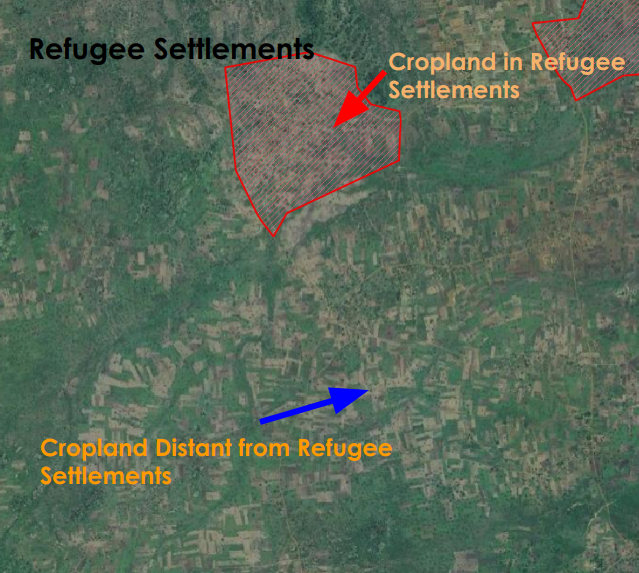

In [35]:
points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([31.888579, 3.469802]), {'id': 'refugee_1'}),
    ee.Feature(
        ee.Geometry.Point([31.894047, 3.450322]), {'id': 'refugee_1_outside'}
    ),
    ee.Feature(ee.Geometry.Point([31.820965, 3.15949]), {'id': 'refugee_2'}),
    ee.Feature(
        ee.Geometry.Point([31.716202, 3.21717]), {'id': 'refugee_2_outside'}
    )
])

ndvi_ts_s2_multipnts = s2_raw.map(
    lambda image: reduce_region(image, points,'NDVI','NDVI_s2',10)
).flatten()
ndvi_ts_mod_multipnts = modis_raw.map(
    lambda image: reduce_region(image, points,'NDVI','NDVI_mod',250)
).flatten()
precip_ts_multipnts = annual_precipitation.map(
    lambda image: reduce_region(image, points,'annual_precipitation',
                                'annual_precipitation',10)
).flatten()
lst_daytime_ts_multipnts = lst_daytime.map(
    lambda image: reduce_region(image, points, 'LST_Day_1km','temperature',1000)
).flatten()

In [36]:
ndvi_ts_mod_multipnts = ndvi_ts_mod_multipnts.getInfo()['features']
ndvi_data_mod_multipnts = [feature['properties']
                           for feature in ndvi_ts_mod_multipnts]
ndvi_mod_df_multipnts = pd.DataFrame(ndvi_data_mod_multipnts)
ndvi_mod_df_multipnts['date'] = pd.to_datetime(ndvi_mod_df_multipnts['date'])

ndvi_ts_s2_multipnts = ndvi_ts_s2_multipnts.getInfo()['features']
ndvi_data_s2_multipnts = [feature['properties']
                          for feature in ndvi_ts_s2_multipnts]
ndvi_s2_df_multipnts = pd.DataFrame(ndvi_data_s2_multipnts)
ndvi_s2_df_multipnts['date'] = pd.to_datetime(ndvi_s2_df_multipnts['date'])

# Note that this time we need to group by both and id so the points will be
# treated separately.
ndvi_s2_df_multipnts = ndvi_s2_df_multipnts.groupby(['date','id']).mean()
ndvi_s2_df_multipnts.reset_index(inplace=True)



precip_ts_multipnts = precip_ts_multipnts.getInfo()['features']
lst_daytime_ts_multipnts = lst_daytime_ts_multipnts.getInfo()['features']

precip_data_multipnts = [feature['properties']
                         for feature in precip_ts_multipnts]
lst_data_multipnts = [feature['properties']
                      for feature in lst_daytime_ts_multipnts]

precip_df_multipnts = pd.DataFrame(precip_data_multipnts)
precip_df_multipnts['date'] = pd.to_datetime(precip_df_multipnts['date'])

lst_df_multipnts = pd.DataFrame(lst_data_multipnts)
lst_df_multipnts['date'] = pd.to_datetime(lst_df_multipnts['date'])



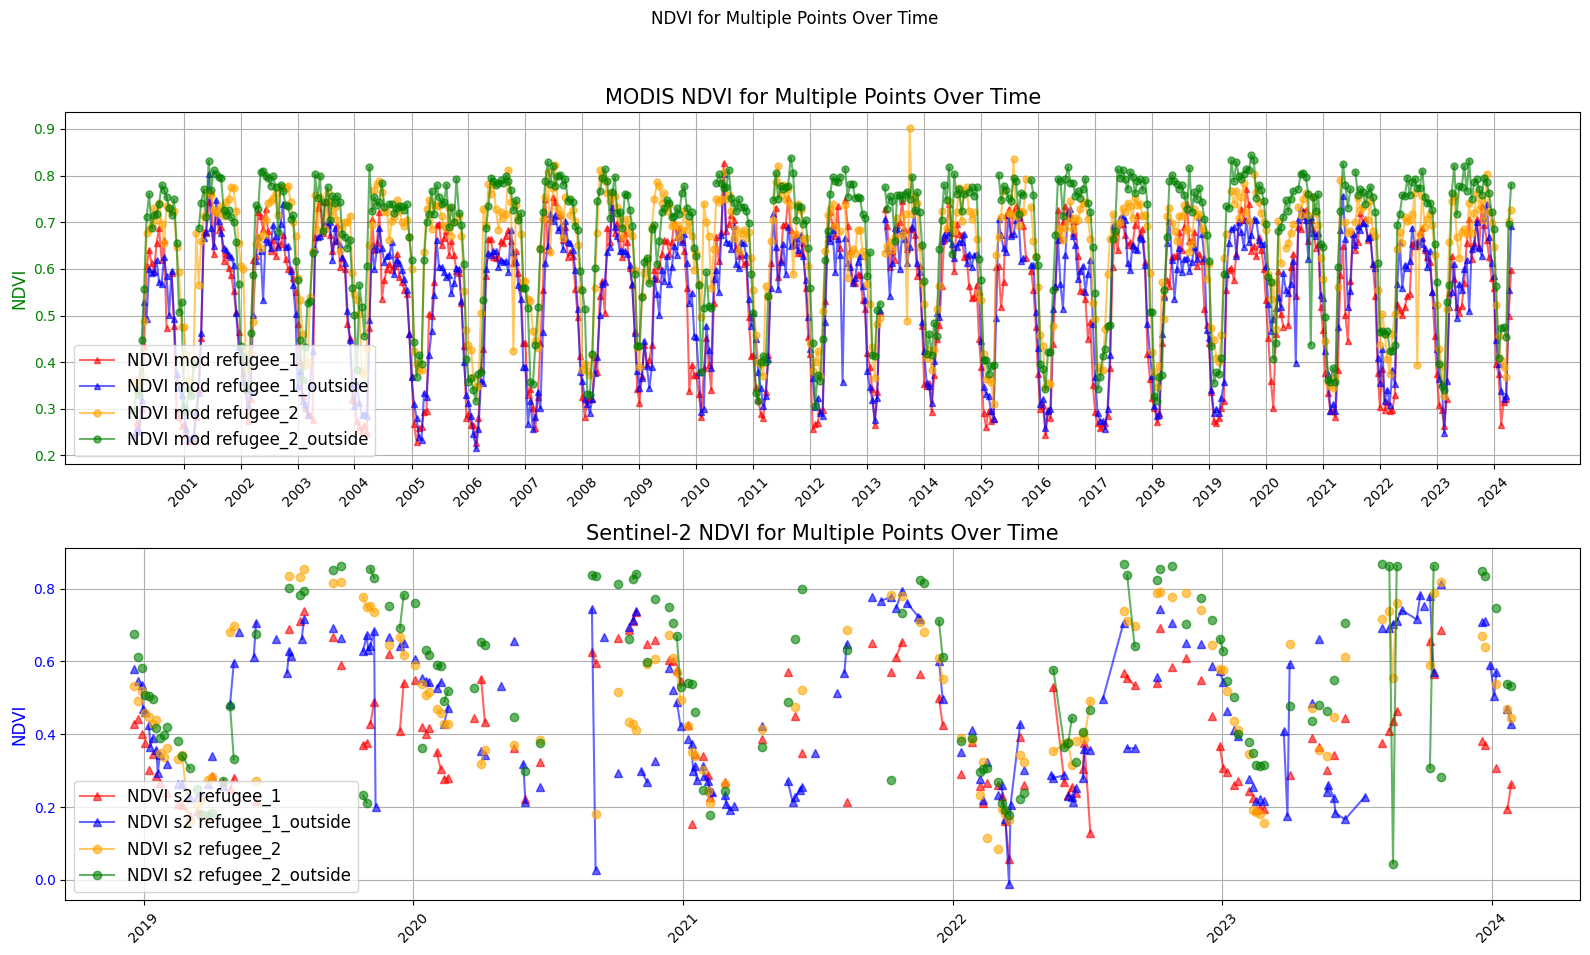

In [37]:

# Define marker styles for different points
marker_styles = {
    'refugee_1': {'marker': '^', 'color': 'red', 'label': 'refugee_1'},
    'refugee_2': {'marker': 'o', 'color': 'orange', 'label': 'refugee_2'},
    'refugee_1_outside': {'marker': '^', 'color': 'blue',
                          'label': 'refugee_1_outside'},
    'refugee_2_outside': {'marker': 'o', 'color': 'green',
                          'label': 'refugee_2_outside'},
    'default': {'marker': 'o', 'color': 'black', 'label': 'default'}
}

# Plotting
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 10), constrained_layout=True)

# First subplot: MODIS NDVI for multiple points
for point_id in ndvi_mod_df_multipnts['id'].unique():
    point_data = ndvi_mod_df_multipnts[ndvi_mod_df_multipnts['id'] == point_id]
    style = marker_styles.get(point_id, marker_styles['default'])
    ax1.plot(point_data['date'], point_data['NDVI_mod'], linestyle='-',
             label=f'NDVI mod {point_id}', marker=style['marker'],
             color=style['color'], markersize=5, alpha=0.6)

ax1.set_ylabel('NDVI', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')

# Set x-ticks to show every year
years = pd.date_range(start=ndvi_mod_df_multipnts['date'].min(),
                      end=ndvi_mod_df_multipnts['date'].max(), freq='YS').year
ax1.set_xticks(pd.date_range(start=ndvi_mod_df_multipnts['date'].min(),
                             end=ndvi_mod_df_multipnts['date'].max(),
                             freq='YS'))
ax1.set_xticklabels(years, rotation=45)

# Title and legends for the first subplot
ax1.set_title('MODIS NDVI for Multiple Points Over Time', fontsize=15)
ax1.legend(loc='lower left', fontsize=12)

# Add grid
ax1.grid(True)

# Second subplot: Sentinel-2 NDVI for multiple points
for point_id in ndvi_s2_df_multipnts['id'].unique():
    point_data = ndvi_s2_df_multipnts[ndvi_s2_df_multipnts['id'] == point_id]
    style = marker_styles.get(point_id, marker_styles['default'])
    ax3.plot(point_data['date'], point_data['NDVI_s2'], linestyle='-',
             label=f'NDVI s2 {point_id}', marker=style['marker'],
             color=style['color'], markersize=6, alpha=0.6)

ax3.set_ylabel('NDVI', color='blue', fontsize=12)
ax3.tick_params(axis='y', labelcolor='blue')

# Set x-ticks to show every year
years = pd.date_range(start=ndvi_s2_df_multipnts['date'].min(),
                      end=ndvi_s2_df_multipnts['date'].max(), freq='YS').year
ax3.set_xticks(pd.date_range(start=ndvi_s2_df_multipnts['date'].min(),
                             end=ndvi_s2_df_multipnts['date'].max(), freq='YS'))
ax3.set_xticklabels(years, rotation=45)

# Title and legends for the second subplot
ax3.set_title('Sentinel-2 NDVI for Multiple Points Over Time', fontsize=15)
ax3.legend(loc='lower left', fontsize=12)

# Add grid
ax3.grid(True)

# Title for the whole figure
fig.suptitle('NDVI for Multiple Points Over Time')

# Adjust layout to prevent clipping of labels and ensure readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to make space title
plt.show()

We apply the gap-filling and curve smoothing for these four points, and extract seasonalities. Still, we just work on MODIS 2000-2023

In [38]:

# Initialize lists to store results for all points
all_mod_ag_years = []
all_mod_phenologies_list = []
all_mod_seasonal_integrals = []

# Interpolation
ndvi_mod_df_multipnts['NDVI_mod'] = (
    ndvi_mod_df_multipnts
    .groupby('id')['NDVI_mod']
    .apply(lambda group: group.interpolate(method='nearest'))
    .reset_index(level=0, drop=True)
)

# Apply Savitzky-Golay filter to each group
window_length = 7  # Window length must be odd
polyorder = 2      # Polynomial order

if len(ndvi_mod_df_multipnts) > window_length:
    ndvi_mod_df_multipnts['NDVI_mod_smooth'] = (
        ndvi_mod_df_multipnts
        .groupby('id')['NDVI_mod']
        .apply(lambda group:
            pd.Series(savgol_filter(group, window_length, polyorder),
                         index=group.index))
        .reset_index(level=0, drop=True)
    )

ndvi_mod_df_multipnts['ag_year'] = ndvi_mod_df_multipnts['date']\
    .apply(custom_year)
ndvi_mod_df_multipnts = ndvi_mod_df_multipnts[
    ndvi_mod_df_multipnts['ag_year'] < 2024
]

# Iterate through each point and agricultural year
for point_id in ndvi_mod_df_multipnts['id'].unique():
    point_data = ndvi_mod_df_multipnts[ndvi_mod_df_multipnts['id'] == point_id]

    mod_ag_years = []
    mod_phenologies_list = []
    mod_seasonal_integrals = []

    for ag_year in point_data['ag_year'].unique():
        mod_ag_years.append(ag_year)
        phenologies = calculate_percentiles(point_data, ag_year,
                                            'NDVI_mod_smooth')
        seasonal_integral = calculate_seasonal_integral(phenologies, point_data,
                                                        'NDVI_mod_smooth')

        mod_seasonal_integrals.append(seasonal_integral)
        mod_phenologies_list.append(phenologies)

    mod_phenologies_df = pd.DataFrame(mod_phenologies_list)
    mod_annual_summary_df = pd.DataFrame({
        'id': point_id,
        'ag_year': mod_ag_years,
        'NDVI_max': mod_phenologies_df['NDVI_max'].values,
        'NDVI_max_date': mod_phenologies_df['NDVI_max_date'].values,
        'NDVI_lmin': mod_phenologies_df['NDVI_lmin'].values,
        'NDVI_lmin_date': mod_phenologies_df['NDVI_lmin_date'].values,
        'NDVI_rmin': mod_phenologies_df['NDVI_rmin'].values,
        'NDVI_rmin_date': mod_phenologies_df['NDVI_rmin_date'].values,
        'NDVI_sos': mod_phenologies_df['NDVI_sos'].values,
        'NDVI_sos_date': mod_phenologies_df['NDVI_sos_date'].values,
        'NDVI_eos': mod_phenologies_df['NDVI_eos'].values,
        'NDVI_eos_date': mod_phenologies_df['NDVI_eos_date'].values,
        'NDVI_seasonal_integral': mod_seasonal_integrals
    })

    mod_annual_summary_df = mod_annual_summary_df[
        mod_annual_summary_df['ag_year'] > 2000
    ]

    all_mod_ag_years.append(mod_annual_summary_df)

# Concatenate all the results into a single DataFrame
final_mod_annual_summary_df = pd.concat(all_mod_ag_years, ignore_index=True)


In [39]:
final_mod_annual_summary_df

id  ag_year  NDVI_max NDVI_max_date  NDVI_lmin  \
0           refugee_1     2001  0.734838    2001-06-10   0.228481   
1           refugee_1     2002  0.720019    2002-05-25   0.300538   
2           refugee_1     2003  0.754686    2003-05-25   0.248348   
3           refugee_1     2004  0.698938    2004-05-08   0.233300   
4           refugee_1     2005  0.688510    2005-07-12   0.242838   
..                ...      ...       ...           ...        ...   
87  refugee_2_outside     2019  0.831243    2019-09-14   0.340019   
88  refugee_2_outside     2020  0.830271    2020-08-28   0.473852   
89  refugee_2_outside     2021  0.788081    2021-05-09   0.336310   
90  refugee_2_outside     2022  0.789848    2022-08-29   0.413629   
91  refugee_2_outside     2023  0.804743    2023-06-26   0.367371   

   NDVI_lmin_date  NDVI_rmin NDVI_rmin_date  NDVI_sos NDVI_sos_date  NDVI_eos  \
0      2001-02-18   0.300538     2002-02-02  0.279117    2001-03-22  0.430828   
1      2002-02-02   0.302324     2003-02-18  0.342486    2002-02-18  0.427632   
2      2003-03-06   0.233300     2004-02-18  0.298981    2003-02-18  0.389716   
3      2004-02-18   0.242838     2005-02-18  0.279864    2004-02-02  0.379668   
4      2005-02-18   0.247290     2006-02-02  0.287405    2005-03-22  0.379656   
..            ...        ...            ...       ...           ...       ...   
87     2019-02-18   0.473852     2020-02-18  0.389141    2019-02-02  0.581070   
88     2020-02-18   0.336310     2021-02-18  0.509494    2020-03-05  0.484498   
89     2021-02-18   0.448452     2022-02-02  0.381487    2021-03-06  0.550341   
90     2022-03-06   0.367371     2023-02-02  0.451250    2022-02-18  0.494114   
91     2023-02-02   0.486405     2024-02-02  0.411109    2023-02-18  0.581906   

   NDVI_eos_date  NDVI_seasonal_integral  
0     2002-01-01              159.064152  
1     2003-01-17              190.153745  
2     2003-12-03              156.075010  
3     2005-01-01              167.663048  
4     2005-12-03              135.337029  
..           ...                     ...  
87    2020-01-17              230.786064  
88    2021-01-17              207.624110  
89    2022-01-01              200.174667  
90    2023-01-01              204.799695  
91    2024-01-17              227.526438  

[92 rows x 13 columns]

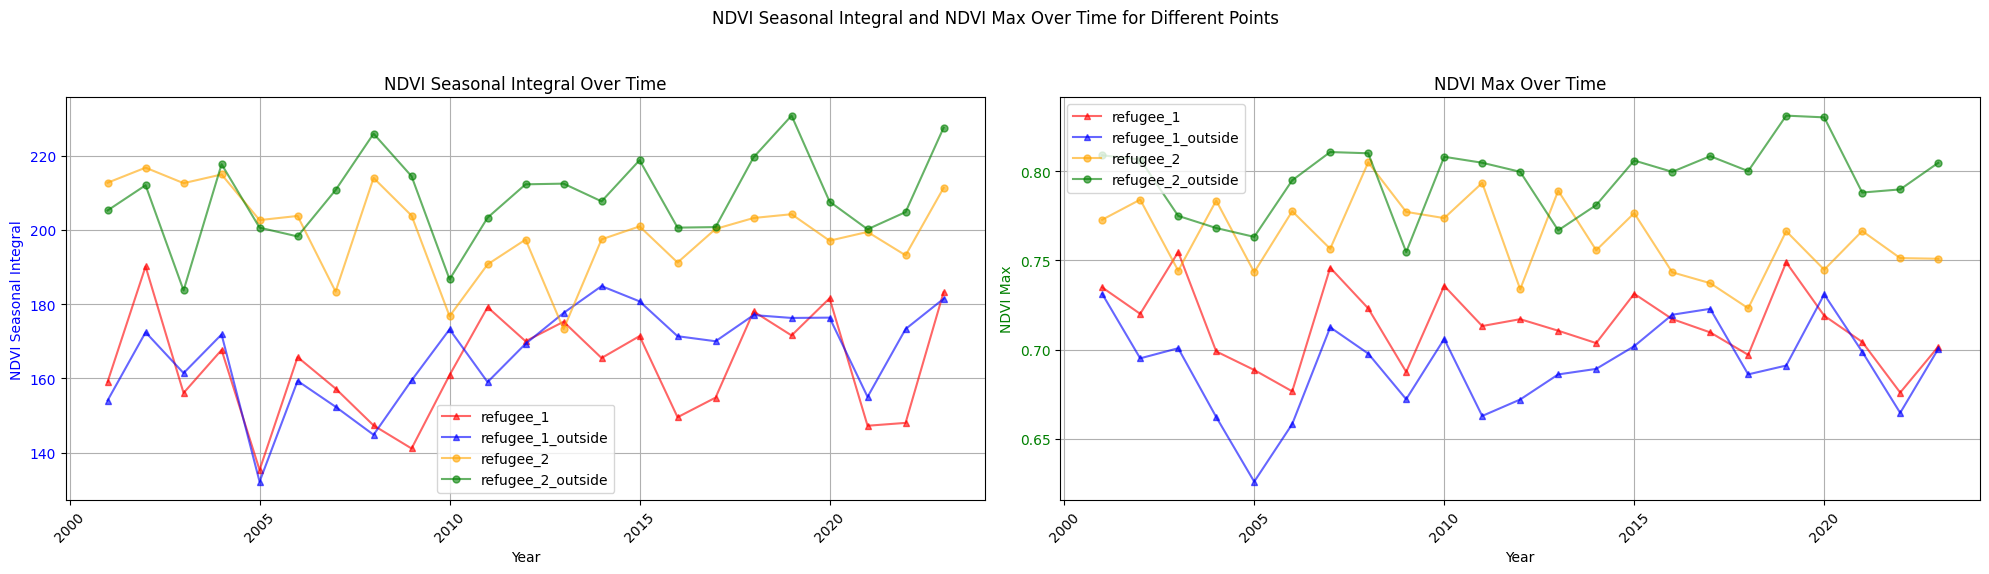

In [40]:

# Define marker styles for different points
marker_styles = {
    'refugee_1': {'marker': '^', 'color': 'red', 'label': 'refugee_1'},
    'refugee_1_outside': {'marker': '^', 'color': 'blue',
                          'label': 'refugee_1_outside'},
    'refugee_2': {'marker': 'o', 'color': 'orange', 'label': 'refugee_2'},
    'refugee_2_outside': {'marker': 'o', 'color': 'green',
                          'label': 'refugee_2_outside'},
    'default': {'marker': 'o', 'color': 'black', 'label': 'default'}
}

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)

# First subplot: NDVI_seasonal_integral
for point_id in final_mod_annual_summary_df['id'].unique():
    point_data = final_mod_annual_summary_df[
        final_mod_annual_summary_df['id'] == point_id
    ]
    style = marker_styles.get(point_id, marker_styles['default'])
    ax1.plot(point_data['ag_year'], point_data['NDVI_seasonal_integral'],
             linestyle='-', label=f'{point_id}', marker=style['marker'],
             color=style['color'], markersize=5, alpha=0.6)

ax1.set_xlabel('Year')
ax1.set_ylabel('NDVI Seasonal Integral', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('NDVI Seasonal Integral Over Time')
ax1.legend(fontsize=10)
ax1.grid(True)

# Second subplot: NDVI_max
for point_id in final_mod_annual_summary_df['id'].unique():
    point_data = final_mod_annual_summary_df[
        final_mod_annual_summary_df['id'] == point_id
    ]
    style = marker_styles.get(point_id, marker_styles['default'])
    ax2.plot(point_data['ag_year'], point_data['NDVI_max'], linestyle='-',
             label=f'{point_id}', marker=style['marker'], color=style['color'],
             markersize=5, alpha=0.6)

ax2.set_xlabel('Year')
ax2.set_ylabel('NDVI Max', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title('NDVI Max Over Time')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True)

# Title for the whole figure
fig.suptitle('NDVI Seasonal Integral and NDVI Max Over Time'\
             ' for Different Points')

# Rotate x-tick labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Adjust layout to prevent clipping of labels and ensure readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [41]:
detrended_df_multipnts = (
    final_mod_annual_summary_df
    .groupby('id').
    apply(lambda group: pd.DataFrame({
        'ag_year': group['ag_year'],
        'NDVI_max_detrended': detrend(group['NDVI_max'], group['ag_year'])[2],
        'NDVI_seasonal_integral_detrended':
        detrend(group['NDVI_seasonal_integral'], group['ag_year'])[2]
    })).reset_index()
)

In [42]:
precip_df_multipnts
final_mod_annual_summary_df

id  ag_year  NDVI_max NDVI_max_date  NDVI_lmin  \
0           refugee_1     2001  0.734838    2001-06-10   0.228481   
1           refugee_1     2002  0.720019    2002-05-25   0.300538   
2           refugee_1     2003  0.754686    2003-05-25   0.248348   
3           refugee_1     2004  0.698938    2004-05-08   0.233300   
4           refugee_1     2005  0.688510    2005-07-12   0.242838   
..                ...      ...       ...           ...        ...   
87  refugee_2_outside     2019  0.831243    2019-09-14   0.340019   
88  refugee_2_outside     2020  0.830271    2020-08-28   0.473852   
89  refugee_2_outside     2021  0.788081    2021-05-09   0.336310   
90  refugee_2_outside     2022  0.789848    2022-08-29   0.413629   
91  refugee_2_outside     2023  0.804743    2023-06-26   0.367371   

   NDVI_lmin_date  NDVI_rmin NDVI_rmin_date  NDVI_sos NDVI_sos_date  NDVI_eos  \
0      2001-02-18   0.300538     2002-02-02  0.279117    2001-03-22  0.430828   
1      2002-02-02   0.302324     2003-02-18  0.342486    2002-02-18  0.427632   
2      2003-03-06   0.233300     2004-02-18  0.298981    2003-02-18  0.389716   
3      2004-02-18   0.242838     2005-02-18  0.279864    2004-02-02  0.379668   
4      2005-02-18   0.247290     2006-02-02  0.287405    2005-03-22  0.379656   
..            ...        ...            ...       ...           ...       ...   
87     2019-02-18   0.473852     2020-02-18  0.389141    2019-02-02  0.581070   
88     2020-02-18   0.336310     2021-02-18  0.509494    2020-03-05  0.484498   
89     2021-02-18   0.448452     2022-02-02  0.381487    2021-03-06  0.550341   
90     2022-03-06   0.367371     2023-02-02  0.451250    2022-02-18  0.494114   
91     2023-02-02   0.486405     2024-02-02  0.411109    2023-02-18  0.581906   

   NDVI_eos_date  NDVI_seasonal_integral  
0     2002-01-01              159.064152  
1     2003-01-17              190.153745  
2     2003-12-03              156.075010  
3     2005-01-01              167.663048  
4     2005-12-03              135.337029  
..           ...                     ...  
87    2020-01-17              230.786064  
88    2021-01-17              207.624110  
89    2022-01-01              200.174667  
90    2023-01-01              204.799695  
91    2024-01-17              227.526438  

[92 rows x 13 columns]

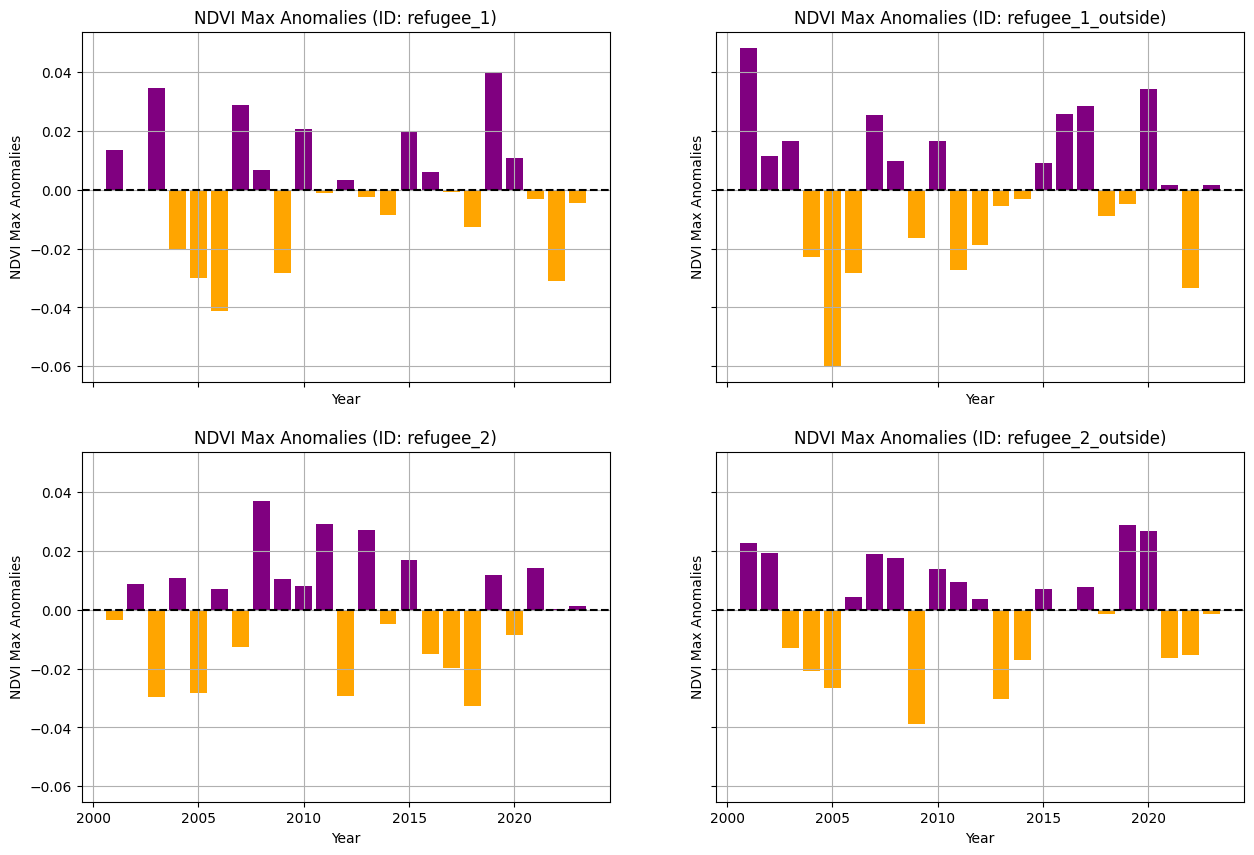

In [43]:
unique_ids = detrended_df_multipnts['id'].unique()

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Flatten axs to iterate over them
axs = axs.flatten()

# Iterate over each ID and plot anomalies
for i, id_val in enumerate(unique_ids):
    df_id = detrended_df_multipnts[detrended_df_multipnts['id'] == id_val]
    colors_max = np.where(df_id['NDVI_max_detrended'] > 0, 'purple', 'orange')
    ax = axs[i]
    ax.bar(df_id['ag_year'], df_id['NDVI_max_detrended'], color=colors_max)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('Year')
    ax.set_ylabel('NDVI Max Anomalies')
    ax.set_title(f'NDVI Max Anomalies (ID: {id_val})')
    ax.grid(True)

Do you observe any patterns from the above productivity anomalies? Which shows more variability, cropland sample points inside or outside refugee settlements? It appears that 'Refugee_1_outside' and 'Refugee_2' exhibit higher variability, at least as measured by NDVI max anomalies. Can we assert that the resilience of croplands within refugee settlements is higher than those outside? Or are we certain that these croplands are cultivated by refugee versus non-refugee populations? We do not have definitive answers based on the information available. However, this type of analysis provides a pathway to explore these questions.

### Conclusion

Congratulations! You have successfully completed this code. Throughout this notebook, we've demonstrated a simple workflow for point-based analysis. However, it's important to note that drawing conclusions about an entire area based on a few points may not be sufficient.

### Next Steps

Throughout Parts 1 to 3 of this workflow, you have learned to analyze data from a single point, and by the end, you expanded your analysis to include four points. As you advance your research, consider sampling additional points and implementing a more rigorous sampling design. This will allow you to further explore the relationships between productivity metrics and weather patterns. Expanding your sample size and enhancing your methodological approach will provide deeper insights into the dynamics of the area under study.

Thank you for participating in this training program. We hope it has been both informative and valuable for your research or project. Should you have any questions or need further assistance, please do not hesitate to reach out.

Wishing you success in your continued analysis!
